In [1]:
# set the number of threads for many common libraries
from os import environ
N_THREADS = '1'
environ['OMP_NUM_THREADS'] = N_THREADS
environ['OPENBLAS_NUM_THREADS'] = N_THREADS
environ['MKL_NUM_THREADS'] = N_THREADS
environ['VECLIB_MAXIMUM_THREADS'] = N_THREADS
environ['NUMEXPR_NUM_THREADS'] = N_THREADS
# https://superfastpython.com/numpy-number-blas-threads/

In [2]:
import pandas as pd
import numpy as np
from itertools import chain

# Hi-C utilities imports:
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag

# Visualization imports:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.ticker import EngFormatter

from itertools import cycle

# from ipywidgets import interact, fixed

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Import modified "guts" of the dotfinder submodule from `helper_func` file

In [3]:
from helper_func import draw_kernel

# turns out still need some of the dotfinder guts in here
from cooltools.api.dotfinder import bp_to_bins, generate_tiles_diag_band
from cooltools.lib.numutils import LazyToeplitz
from cooltools.lib.common import assign_regions

from datashader.mpl_ext import dsshow, alpha_colormap
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from data_catalog import bws, bws_vlim, telo_dict


In [192]:
from bioframe.core import checks, construction
from bioframe.core.specs import _get_default_colnames, _verify_columns
from bioframe.core.stringops import parse_region


def merge_nested_intervals(starts, ends, stickout_dist=0, stick_frac=1.1):
    """
    Merge overlapping intervals.

    Parameters
    ----------
    starts, ends : numpy.ndarray
        Interval coordinates. Warning: if provided as pandas.Series, indices
        will be ignored.

    Returns
    -------
    cluster_ids : numpy.ndarray
        The indices of interval clusters that each interval belongs to.
    cluster_starts : numpy.ndarray
    cluster_ends : numpy.ndarray
        The spans of the merged intervals.

    Notes
    -----
    From
    https://stackoverflow.com/questions/43600878/merging-overlapping-intervals/58976449#58976449
    """

    for vec in [starts, ends]:
        if isinstance(vec, pd.Series):
            warnings.warn(
                "One of the inputs is provided as pandas.Series and its index "
                "will be ignored.",
                SyntaxWarning,
                stacklevel=2,
            )

    starts = np.asarray(starts)
    ends = np.asarray(ends)

    order = np.lexsort([ends, starts])
    starts, ends = starts[order], ends[order]

    ends = np.maximum.accumulate(ends)
    cluster_borders = np.zeros(len(starts) + 1, dtype=bool)
    cluster_borders[0] = True
    cluster_borders[-1] = True

    # ... MODIFICATION ...
    # cluster borders are where start of next interval is beyond the end of previous one
    # or the end of next interval "sticks out" relative to the end of the previous one ...
    _overlaps = ( ends[:-1] - starts[1:] )
    _stickout_sizes = ( ends[1:] - ends[:-1] )
    # _interval_sizes = ( ends - starts )
    # break clusters when there is no overlap at all, or the next interval mostly sticks out ...
    cluster_borders[1:-1] = (_overlaps < 0) | ( _stickout_sizes > stick_frac*_overlaps)
    # cluster_borders[1:-1] = (_stickout_sizes > stickout_dist)
    # cluster_borders[1:-1] = (starts[1:] >= ends[:-1]) | (ends[1:] > ends[:-1])
    # ... END MODIFICATION ...

    cluster_ids_sorted = np.cumsum(cluster_borders)[:-1] - 1
    cluster_ids = np.full(starts.shape[0], -1)
    cluster_ids[order] = cluster_ids_sorted

    cluster_starts = starts[:][cluster_borders[:-1]]
    cluster_ends = ends[:][cluster_borders[1:]]

    return cluster_ids, cluster_starts, cluster_ends


def merge_nested(df, stickout_dist=0, cols=None, on=None):
    """
    Merge overlapping intervals.

    This returns a new dataframe of genomic intervals, which have the genomic
    coordinates of the interval cluster groups from the input dataframe. Also
    :func:`cluster()`, which returns the assignment of intervals to clusters
    prior to merging.

    Parameters
    ----------
    df : pandas.DataFrame

    cols : (str, str, str) or None
        The names of columns containing the chromosome, start and end of the
        genomic intervals. The default values are 'chrom', 'start', 'end'.

    on : None or list
        List of column names to perform clustering on independently, passed as
        an argument to df.groupby before clustering. Default is None.
        An example useage would be to pass ``on=['strand']``.

    Returns
    -------
    df_merged : pandas.DataFrame
        A pandas dataframe with coordinates of merged clusters.

    Notes
    -------
    Resets index.

    """

    # Allow users to specify the names of columns containing the interval coordinates.
    ck, sk, ek = _get_default_colnames() if cols is None else cols
    checks.is_bedframe(df, raise_errors=True, cols=[ck, sk, ek])

    df = df.copy()
    df.reset_index(inplace=True, drop=True)

    # Find overlapping intervals for groups specified by on=[] (default on=None)
    group_list = [ck]
    if on is not None:
        if not isinstance(on, list):
            raise ValueError("on=[] must be None or list")
        if ck in on:
            raise ValueError("on=[] should not contain chromosome colnames")
        _verify_columns(df, on)
        group_list += on
    df_groups = df.groupby(group_list, observed=True).groups

    clusters = []

    for group_keys, df_group_idxs in df_groups.items():
        if pd.isna(pd.Series(group_keys)).any():
            continue
        if df_group_idxs.empty:
            continue

        df_group = df.loc[df_group_idxs]
        (
            cluster_ids_group,
            cluster_starts_group,
            cluster_ends_group,
        ) = merge_nested_intervals(
            df_group[sk].values.astype(np.int64),
            df_group[ek].values.astype(np.int64),
            stickout_dist=stickout_dist,
        )
        interval_counts = np.bincount(cluster_ids_group)
        n_clusters = cluster_starts_group.shape[0]

        ## Storing chromosome names causes a 2x slowdown. :(
        if isinstance(group_keys, str):
            group_keys = (group_keys,)
        clusters_group = {}
        for col in group_list:
            clusters_group[col] = pd.Series(
                data=np.full(n_clusters, group_keys[group_list.index(col)]),
                dtype=df[col].dtype,
            )
        clusters_group[sk] = cluster_starts_group
        clusters_group[ek] = cluster_ends_group
        clusters_group["n_intervals"] = interval_counts
        clusters_group = pd.DataFrame(clusters_group)

        clusters.append(clusters_group)

    df_nans = pd.isnull(df[[sk, ek, *group_list]]).any(axis=1)
    df_has_nans = df_nans.sum()
    if df_has_nans:
        nan_intervals = pd.DataFrame(
            [pd.NA] * df_has_nans,
            columns=["n_intervals"],
            index=df.loc[df_nans].index,
        )
        clusters.append(
            pd.concat(
                [df.loc[df_nans], nan_intervals],
                axis=1,
            )
        )

    clusters = pd.concat(clusters).reset_index(drop=True)
    if df_has_nans:
        clusters = clusters.astype(
            {sk: pd.Int64Dtype(), ek: pd.Int64Dtype(), "n_intervals": pd.Int64Dtype()}
        )

    # reorder cluster columns to have chrom,start,end first
    clusters_names = list(clusters.keys())
    clusters = clusters[
        [ck, sk, ek] + [col for col in clusters_names if col not in [ck, sk, ek]]
    ]

    return clusters


### pick a dataset and binsize to work on ...

In [5]:
# # ! pip install --upgrade --no-cache --no-deps --ignore-install cooler
# # ls /home/dekkerlab/dots-test
# # import higlass as hg
# import jscatter
import scipy
import logging
import multiprocess as mp
# import mpire for nested multi-processing
from mpire import WorkerPool

In [6]:
# ! ls /data/proj_sync/data_ranger/finalcoolers_mega/ranGAP1-aux-G1s-MEGA.hg38.mapq_30.1000.mcool

# 10 kb is a resolution at which one can clearly see "dots":
binsize = 10_000
# cooler files that we'll work on :
telo_clrs = { _k: cooler.Cooler(f"{_path}::/resolutions/{binsize}") for _k, _path in telo_dict.items() }


### pick a region to work on ...

In [7]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms_full = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
# # remove "bad" chromosomes and near-empty arms ...
# excluded_arms = ["chr13_p", "chr14_p", "chr15_p", "chr21_p", "chr22_p", "chrM_p", "chrY_p", "chrY_q", "chrX_p", "chrX_q"]
# hg38_arms = hg38_arms_full[~hg38_arms_full["name"].isin(excluded_arms)].reset_index(drop=True)

# can do 1 chromosome (or arm) as well ..
included_arms = ["chr1_q", "chr2_p", "chr4_q", "chr6_q"]
included_arms = hg38_arms_full["name"].to_list()[:44] # all autosomal ones ...
hg38_arms = hg38_arms_full[hg38_arms_full["name"].isin(included_arms)].reset_index(drop=True)

### pre-calculate expected for the cooler ...

In [8]:
def _job(packed_data, sample):
    # packed data -> exp_kwargs and a dict with coolers for each sample
    exp_kwargs, clr_dict = packed_data
    _clr = clr_dict[sample]
    # in order to use spawn/forkserver we have to import for worker
    from cooltools import expected_cis
    _exp = expected_cis( _clr, **exp_kwargs)
    return (sample, _exp)

# define expected parameters in the form of kwargs-dict:
exp_kwargs = dict(
    view_df=hg38_arms,
    intra_only=False,
    nproc=12
)

# have to use daemon=False, because _job is multiprocessing-based already ...
with WorkerPool(
    n_jobs=8,
    daemon=False,
    shared_objects=( exp_kwargs, telo_clrs ),
    start_method="forkserver",  # little faster than spawn, fork is the fastest
    use_dill=True,
) as wpool:
    results = wpool.map(_job, telo_clrs, progress_bar=True)

# sort out the results ...
telo_exps_cis = {sample: _exp for sample, _exp in results}
# # old way of doing it
# telo_exps_cis = {k: cooltools.expected_cis( _clr, **exp_kwargs) for k, _clr in telo_clrs.items()}

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:09<00:00,  3.60s/it]


# generate custom kernels - similar to original from hiccups

In [9]:
# define stripy kernels for small compartment detection ...
def get_stripy_kernels_new(halfwidth):
    """
    halfwidth : int
        half width of the kernel, kernel size must be odd number in both dimensions

    returns :
    dictionaty with kernels
    """
    # kernel width defined - odd dimensions ...
    kwidth = (2*halfwidth + 1)
    # define str|ipe width
    stripe_width = kwidth // 3

    # create a grid of coordinates from -h to +h, to define round kernels
    x, y = np.meshgrid(
        np.linspace(-halfwidth, halfwidth, kwidth),
        np.linspace(-halfwidth, halfwidth, kwidth),
    )

    # define horizontal and vertical stripes
    maskv = ((x < stripe_width - halfwidth) | (x > halfwidth - stripe_width))
    maskv = maskv & ((y >= stripe_width - halfwidth) & (y <= halfwidth - stripe_width))
    maskvmid = ~maskv & ((y >= stripe_width - halfwidth) & (y <= halfwidth - stripe_width))
    maskh = ((y < stripe_width - halfwidth) | (y > halfwidth - stripe_width))
    maskh = maskh & ((x >= stripe_width - halfwidth) & (x <= halfwidth - stripe_width))
    maskhmid = ~maskh & ((x >= stripe_width - halfwidth) & (x <= halfwidth - stripe_width))

    # new kernels with more round donut and lowleft masks:
    return {
        f'mid': maskvmid,
        f'v{halfwidth}': maskv,
        f'h{halfwidth}': maskh,
    }

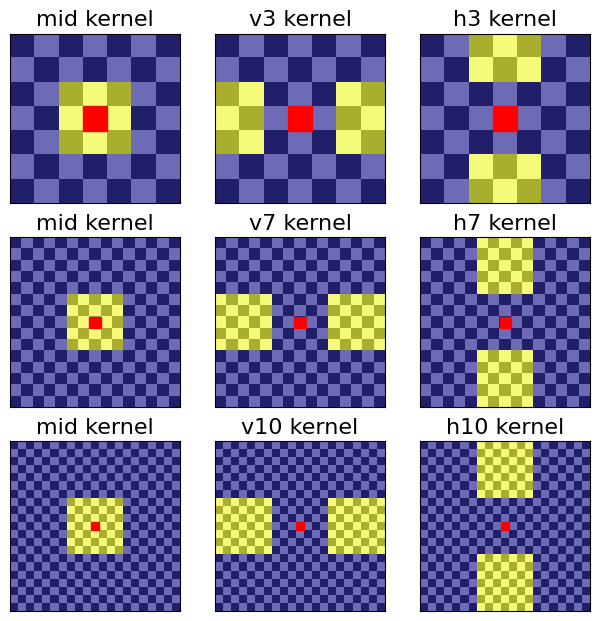

In [10]:
# define stripy kernels of different sizes
k4 = get_stripy_kernels_new(halfwidth=3)
k7 = get_stripy_kernels_new(halfwidth=7)
kl = get_stripy_kernels_new(halfwidth=10)


# plot rounded kernels
fig, axs = plt.subplots(ncols=len(k4), nrows=len([k4, k7, kl]), figsize=(len(k4)*2.5, len([k4, k7, kl])*2.5), squeeze=False)
for ax_row, ks in zip(axs, [k4, k7, kl]):
    for ax, (ktype, kernel) in zip(ax_row, ks.items()):
        imk = draw_kernel(kernel, ax, kernel_name=ktype,cmap="plasma")

## Work on a particular clr/exp pair - mostly the 5hr sample ...

In [11]:
clr = telo_clrs["p5hR1R2"]
exp = telo_exps_cis["p5hR1R2"]
exp_indexed = exp.set_index(["region1", "region2"])

# Working on a Figure here - just load the calls:
 - enriched pixels
 - clustered pixels
 - existing anchors ...
...

In [12]:
id_anchor_fnames = {
    "mega_2X_enrichment": "ID_anchors/mega_2X_enrichment.fourth_mega.max_size.bed",
    "5hr_2X_enrichment_old": "ID_anchors/5hr_2X_enrichment.second_bulk.max_size.bed",
    "5hr_2X_enrichment": "ID_anchors/5hr_2X_enrichment.pixel_derived.bed",
    "5hr_2X_enrichment_nosing": "ID_anchors/5hr_2X_enrichment.pixel_derived.no_singletons.bed",
    "5hr_notinCyto_2X_enrichment_signal": "ID_anchors/p5notin_pCyto_anchors_2X_enrichment.pixel_derived.signal_peaks.bed",
    "5hr_2X_enrichment_signal": "ID_anchors/5hr_2X_enrichment.pixel_derived.signal_peaks.bed",
    "10hr_2X_enrichment_signal": "ID_anchors/10hrs_2X_enrichment.pixel_derived.signal_peaks.bed",
    "N93p5_2X_enrichment_signal": "ID_anchors/N93p5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "pCyto_2X_enrichment_signal": "ID_anchors/pCyto_2X_enrichment.pixel_derived.signal_peaks.bed",
    "mCyto_2X_enrichment_signal": "ID_anchors/mCyto_2X_enrichment.pixel_derived.signal_peaks.bed",
    "mega_3X_enrichment": "ID_anchors/mega_3X_enrichment.fifth_mega3x.max_size.bed",
    "MEGA_2X_enrichment": "ID_anchors/MEGAp5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGA_weaker_2X_enrichment": "ID_anchors/MEGA_plus_weak_anchors_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGAN93_2X_enrichment": "ID_anchors/MEGAN93p5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGAminus_2X_enrichment": "ID_anchors/MEGA_minus_ctrl_2X_enrichment.pixel_derived.signal_peaks.bed",
    "cyto_2x_enrichment": "ID_anchors/cyto_2x_enrichment.third_mCyto.max_size.bed",
}

id_anchors_dict = {}
for id_name, fname in id_anchor_fnames.items():
    id_anchors_dict[id_name] = pd.read_csv(fname, sep="\t")
    # ...
    print(f"loaded {len(id_anchors_dict[id_name]):5d} ID anchors {id_name:>20} in BED format ...")


# _anchors5 = id_anchors_dict["MEGA_2X_enrichment"]
_anchors5 = id_anchors_dict["5hr_2X_enrichment_signal"]
_anchorsCyto = id_anchors_dict["pCyto_2X_enrichment_signal"]
# ! ls native_comps_10kb
# ! ls enriched_pixels_10kb

loaded  6760 ID anchors   mega_2X_enrichment in BED format ...
loaded  4200 ID anchors 5hr_2X_enrichment_old in BED format ...
loaded  2199 ID anchors    5hr_2X_enrichment in BED format ...
loaded  2118 ID anchors 5hr_2X_enrichment_nosing in BED format ...
loaded  1407 ID anchors 5hr_notinCyto_2X_enrichment_signal in BED format ...
loaded  2105 ID anchors 5hr_2X_enrichment_signal in BED format ...
loaded  1792 ID anchors 10hr_2X_enrichment_signal in BED format ...
loaded   555 ID anchors N93p5_2X_enrichment_signal in BED format ...
loaded   853 ID anchors pCyto_2X_enrichment_signal in BED format ...
loaded   963 ID anchors mCyto_2X_enrichment_signal in BED format ...
loaded  1625 ID anchors   mega_3X_enrichment in BED format ...
loaded  4623 ID anchors   MEGA_2X_enrichment in BED format ...
loaded  2080 ID anchors MEGA_weaker_2X_enrichment in BED format ...
loaded  1307 ID anchors MEGAN93_2X_enrichment in BED format ...
loaded  2778 ID anchors MEGAminus_2X_enrichment in BED format ...


In [13]:
# loading enriched pixels ...
enrich_fnames = {
    "5hr_2X_enrichment": "enriched_pixels_10kb/5hr_2X_second.binpe",
}
# let's load them all into a dictionary ...
enriched_dict = {}
for id_name, fname in enrich_fnames.items():
    enriched_dict[id_name] = pd.read_csv(fname, sep="\t")
    # ...
    print(f"loaded {len(enriched_dict[id_name]):5d} enriched pixels {id_name:>20} in BEDPE format ...")

# loading ID interactions ...
print("...")
ids_fnames = {
    "mega_2X_enrichment": "native_comps_10kb/fourth_mega.bedpe",
    "5hr_2X_enrichment_old": "native_comps_10kb/second_bulk.bedpe",
    "5hr_2X_enrichment": "native_comps_10kb/5hr_2X_second.bedpe",
    "mega_3X_enrichment": "native_comps_10kb/fifth_mega3x.bedpe",
    "cyto_2x_enrichment": "native_comps_10kb/third_mCyto.bedpe",
}
# let's load them all into a dictionary ...
ids_dict = {}
for id_name, fname in ids_fnames.items():
    ids_dict[id_name] = pd.read_csv(fname, sep="\t")
    # ...
    print(f"loaded {len(ids_dict[id_name]):5d} ID interactions {id_name:>20} in BEDPE format ...")


# loading anchors here ...
print("...")
id_anchor_fnames = {
    "mega_2X_enrichment": "ID_anchors/mega_2X_enrichment.fourth_mega.max_size.bed",
    "5hr_2X_enrichment_old": "ID_anchors/5hr_2X_enrichment.second_bulk.max_size.bed",
    "5hr_2X_enrichment": "ID_anchors/5hr_2X_enrichment.pixel_derived.bed",
    "5hr_2X_enrichment_nosing": "ID_anchors/5hr_2X_enrichment.pixel_derived.no_singletons.bed",
    "5hr_notinCyto_2X_enrichment_signal": "ID_anchors/p5notin_pCyto_anchors_2X_enrichment.pixel_derived.signal_peaks.bed",
    "5hr_2X_enrichment_signal": "ID_anchors/5hr_2X_enrichment.pixel_derived.signal_peaks.bed",
    "10hr_2X_enrichment_signal": "ID_anchors/10hrs_2X_enrichment.pixel_derived.signal_peaks.bed",
    "N93p5_2X_enrichment_signal": "ID_anchors/N93p5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "pCyto_2X_enrichment_signal": "ID_anchors/pCyto_2X_enrichment.pixel_derived.signal_peaks.bed",
    "mCyto_2X_enrichment_signal": "ID_anchors/mCyto_2X_enrichment.pixel_derived.signal_peaks.bed",
    "mega_3X_enrichment": "ID_anchors/mega_3X_enrichment.fifth_mega3x.max_size.bed",
    "MEGA_2X_enrichment": "ID_anchors/MEGAp5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGA_weaker_2X_enrichment": "ID_anchors/MEGA_plus_weak_anchors_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGAN93_2X_enrichment": "ID_anchors/MEGAN93p5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGAminus_2X_enrichment": "ID_anchors/MEGA_minus_ctrl_2X_enrichment.pixel_derived.signal_peaks.bed",
    "cyto_2x_enrichment": "ID_anchors/cyto_2x_enrichment.third_mCyto.max_size.bed",
}

id_anchors_dict = {}
for id_name, fname in id_anchor_fnames.items():
    id_anchors_dict[id_name] = pd.read_csv(fname, sep="\t")
    # ...
    print(f"loaded {len(id_anchors_dict[id_name]):5d} ID anchors {id_name:>20} in BED format ...")


loaded 167288 enriched pixels    5hr_2X_enrichment in BEDPE format ...
...
loaded 26888 ID interactions   mega_2X_enrichment in BEDPE format ...
loaded  8135 ID interactions 5hr_2X_enrichment_old in BEDPE format ...
loaded  9413 ID interactions    5hr_2X_enrichment in BEDPE format ...
loaded  2786 ID interactions   mega_3X_enrichment in BEDPE format ...
loaded  2158 ID interactions   cyto_2x_enrichment in BEDPE format ...
...
loaded  6760 ID anchors   mega_2X_enrichment in BED format ...
loaded  4200 ID anchors 5hr_2X_enrichment_old in BED format ...
loaded  2199 ID anchors    5hr_2X_enrichment in BED format ...
loaded  2118 ID anchors 5hr_2X_enrichment_nosing in BED format ...
loaded  1407 ID anchors 5hr_notinCyto_2X_enrichment_signal in BED format ...
loaded  2105 ID anchors 5hr_2X_enrichment_signal in BED format ...
loaded  1792 ID anchors 10hr_2X_enrichment_signal in BED format ...
loaded   555 ID anchors N93p5_2X_enrichment_signal in BED format ...
loaded   853 ID anchors pCyto_2X

# Load pre-called dots as well ...

In [14]:
############################################# anchors ...
anchor_fnames = {
    "mega_ctrl": "dot_anchors_10kb_MEGA/mG1s_MEGA.bed",
}
# ...
dot_anchors_dict = {}
for id_name, fname in anchor_fnames.items():
    dot_anchors_dict[id_name] = pd.read_csv(fname, sep="\t")
    # ...
    print(f"loaded {len(dot_anchors_dict[id_name]):5d} ID anchors {id_name:>20} in BED format ...")
# ...
############################################# dots themselves ...
dot_fnames = {
    "mega_ctrl": "dots_10kb_MEGA_samples/mG1s_MEGA_10kb_wheader.bedpe",
    "mega_depl": "dots_10kb_MEGA_samples/pG1s_MEGA_10kb_wheader.bedpe",
    "mega_mito": "dots_10kb_MEGA_samples/Ms_MEGA_10kb_wheader.bedpe",
    "cyto": "dots_10kb_samples/mCyto_10kb_wheader.bedpe",
}
# ...
# let's load them all into a dictionary ...
dots_dict = {}
for id_name, fname in dot_fnames.items():
    dots_dict[id_name] = pd.read_csv(fname, sep="\t")
    # ...
    print(f"loaded {len(dots_dict[id_name]):5d} dots {id_name:>20} in BEDPE format ...")

# pick specific anchors and dots ...
_the_anchors = dot_anchors_dict["mega_ctrl"]
_the_dots = dots_dict["mega_ctrl"]


# _the_dots = bioframe.sort_bedframe(
#     _the_dots,
#     view_df=hg38_arms,
#     cols=("chrom1","start1","start2")
# )
_the_dots = _the_dots.sort_values(by=["chrom1", "start1", "start2"]).reset_index(drop=True)

# (_the_dots.groupby(["chrom1", "start1"]).ngroup() - \
#  _the_dots.groupby(["chrom2", "start2"]).ngroup()).value_counts().plot()

# _the_dots.eval("dist=start2 - start1")
# _the_dots.sort_values(by=["chrom1","start1", "start2"]).reset_index(drop=True)

loaded 29289 ID anchors            mega_ctrl in BED format ...
loaded 27373 dots            mega_ctrl in BEDPE format ...
loaded 18077 dots            mega_depl in BEDPE format ...
loaded   713 dots            mega_mito in BEDPE format ...
loaded  8170 dots                 cyto in BEDPE format ...


# Explore enriched pixels and derive good anchors ...

In [16]:
_condition = "5hr_2X_enrichment"
enriched_pixels = enriched_dict["5hr_2X_enrichment"]
clustered_pixels = ids_dict["5hr_2X_enrichment"]
clustered_pixels_old = ids_dict["5hr_2X_enrichment_old"]

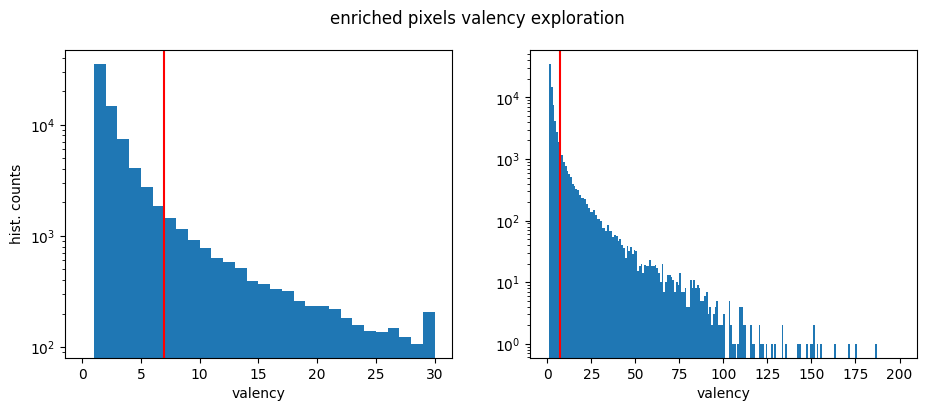

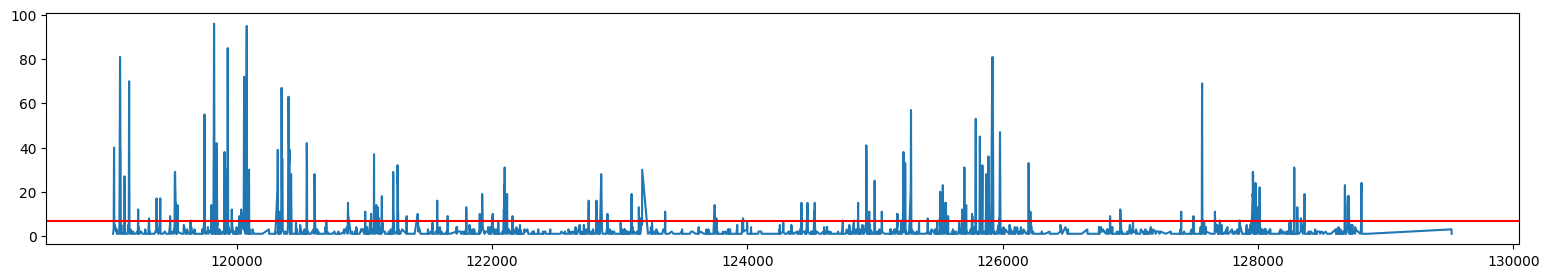

In [17]:
# simply count "valencies" of enriched pixels i-s and j-s - and sum tham up togeher ...
b1ser = enriched_pixels.groupby("bin1_id").size()
b2ser = enriched_pixels.groupby("bin2_id").size()

b1ser.index.name = "bin"
b2ser.index.name = "bin"

rich_pix_vals = b1ser.add(b2ser, fill_value=0)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(11,4))

_max_val = 30
_val_thresh = 7
axs[0].hist(rich_pix_vals, bins=np.linspace(0,_max_val,_max_val+1), log=True);
axs[0].axvline(_val_thresh,color="red")
axs[0].set_xlabel("valency")
axs[0].set_ylabel("hist. counts")
_max_val = 200
axs[1].hist(rich_pix_vals, bins=np.linspace(0,_max_val,_max_val+1), log=True);
axs[1].axvline(_val_thresh,color="red")
axs[1].set_xlabel("valency")


fig.suptitle("enriched pixels valency exploration")

f,ax = plt.subplots(figsize=(19,3))
ax.plot(rich_pix_vals.loc[119022:129522])
ax.axhline(7,color="red")
# ax = plt.gca()
# ax.set_yscale("log")

In [18]:
# filter pixel indexes by valency, turn them to bins and cluster/bioframe ...
_val_threshold = 10

# _idx = rich_pix_vals[rich_pix_vals > _val_threshold].index
_rich_bins = clr.bins()[:].loc[rich_pix_vals[rich_pix_vals > _val_threshold].index]
# # _rich_bins

_new_anchors = bioframe.merge(_rich_bins)
_new_anchors = _new_anchors.reset_index().rename(columns={"index":"cluster"})
# _new_anchors

# This is another approach where we pick the most prominent bin per anchor ...
#
# # save them ...
# _new_anchors["size"] = _new_anchors.eval("end - start")
# _new_anchors["valency"] = 10
# _new_anchors[["chrom","start","end","cluster","size","valency"]].to_csv("new_anchors_test.bed",index=False,sep="\t")
#
# # try this one, where we pick the most prolific bin per anchor ...
# _rich_bins["valency"] = rich_pix_vals.loc[_rich_bins.index]
# _rich_bins_clust = bioframe.cluster(_rich_bins)
# _new_anchors = _rich_bins_clust.loc[_rich_bins_clust.groupby("cluster")["valency"].idxmax()]
# _rich_bins_clust.tail(30)
# _new_anchors["size"] = _new_anchors.eval("cluster_end - cluster_start")
# _new_anchors[["chrom","start","end","cluster","size","valency"]].to_csv("new_new_anchors_test.bed",index=False,sep="\t")


def calculate_valencies(
    bed_df,  # must be output of bedpe_to_anchors, which in turn is a clustering inside
    bedpe_df,
    cluster_colname = "cluster",
    valency_colname = "valency",
    bed_cols = ["chrom", "cluster_start", "cluster_end"],
    bedpe_cols1 = ["chrom1", "start1", "end1"],
    bedpe_cols2 = ["chrom2", "start2", "end2"],
):
    """
    calculate valencies of a given anchors, given the bedpe ...
    """

    if cluster_colname not in bed_df.columns:
        raise ValueError("bed_df does not seem to be the result of bedpe_to_anchors/clustering ...")

    # overlap combined anchors with the left anchors to see how many "dots" we overlap ...
    anchors_left = bioframe.overlap(
        bed_df,
        bedpe_df,
        how='left',
        cols1=bed_cols,
        cols2=bedpe_cols1,
    ).dropna( subset=[f"{c}_" for c in bedpe_cols1] )

    # overlap combined anchors with the right anchors to see how many "dots" we overlap ...
    anchors_right = bioframe.overlap(
        bed_df,
        bedpe_df,
        how='left',
        cols1=bed_cols,
        cols2=bedpe_cols2,
    ).dropna( subset=[f"{c}_" for c in bedpe_cols2] )

    _num_clusters = len(bed_df)
    # sanity check here ... - make sure we cover all of the cluster that are available ...
    assert ( bed_df[cluster_colname].sort_values() == np.arange(_num_clusters) ).all()
    # ...
    _empty_clust_series = pd.Series(
        data=np.zeros(_num_clusters),
        index=pd.Index(data=np.arange(_num_clusters), name=cluster_colname),
        name="count"
    )

    # calculate valencies ...
    _valencies = (_empty_clust_series + anchors_left[cluster_colname].value_counts()).fillna(0) \
                + (_empty_clust_series + anchors_right[cluster_colname].value_counts()).fillna(0)

    # assign valencies back to anchors bed_df - carefully !
    # _valencies are indexed using cluster_id - s
    bed_df_clust_indexed = bed_df.set_index(cluster_colname)
    bed_df_clust_indexed[valency_colname] = _valencies.astype(int)
    #
    return bed_df_clust_indexed.reset_index()


In [19]:
# add few extra columns and save it ...
_new_anchors["size"] = _new_anchors.eval("end - start")
# calculate valency the old way by overlapping with actually clustered pixels ...
_new_anchors = calculate_valencies(
    _new_anchors,  # must be output of bedpe_to_anchors, which in turn is a clustering inside
    clustered_pixels,
    cluster_colname = "cluster",
    valency_colname = "valency",
    bed_cols = ["chrom", "start", "end"],
    bedpe_cols1 = ["chrom1", "start1", "end1"],
    bedpe_cols2 = ["chrom2", "start2", "end2"],
)
# # save it ...
# _cols_save = ["chrom","start","end","cluster","size","valency"]
# dirname = "ID_anchors"
# fname = f"{dirname}/5hr_2X_enrichment.pixel_derived.bed"
# _new_anchors[_cols_save].to_csv(
#     fname,
#     index=False,
#     sep="\t",
# )

# Pick one condition to explore `5hr_2X_enrichment` ...

In [20]:

_region1 = ('chr6', 129_000_000, 129_000_000+1_500_000)
_region2 = ('chr6', 129_000_000, 129_000_000+3_700_000)

# _region1 = ('chr6', 129_000_000, 129_000_000+1_500_000)
# _region2 = ('chr6', 129_000_000, 129_000_000+3_700_000)


region1_name = bioframe.select(hg38_arms, _region1).iat[0,-1]
region2_name = bioframe.select(hg38_arms, _region2).iat[0,-1]
assert region1_name == region2_name
region_name = region2_name

tile_span_i = clr.extent(_region1)
tile_span_j = clr.extent(_region2)
_the_tile = (region_name, tile_span_i, tile_span_j )

tile_start_ij = (tile_span_i[0], tile_span_j[0])
lazy_exp = LazyToeplitz(
    exp_indexed.loc[region_name, region_name]["balanced.avg"].to_numpy()
)
# RAW observed matrix slice:
observed = clr.matrix()[slice(*tile_span_i), slice(*tile_span_j)]
expected = lazy_exp[slice(*tile_span_i), slice(*tile_span_j)]

# let's figure out slices' coordinates ....
_bins_i = clr.bins()[slice(*tile_span_i)]
_bins_j = clr.bins()[slice(*tile_span_j)]
_chrom_i, _start_i, _end_i = _bins_i.iloc[0]["chrom"], _bins_i.iloc[0]["start"], _bins_i.iloc[-1]["end"]
_chrom_j, _start_j, _end_j = _bins_j.iloc[0]["chrom"], _bins_j.iloc[0]["start"], _bins_j.iloc[-1]["end"]



gOE = scipy.ndimage.gaussian_filter(
    (observed/expected),
    sigma=0.4,
    order=0,
    mode='reflect',
    cval=0.0,
    # radius=3,
    truncate=1.0,
)



# _region1_zoom = ('chr6', 129_550_000, 129_550_000 + 280_000)
# _region2_zoom = ('chr6', 130_310_000, 130_310_000 + 380_000)
_region1_zoom = ('chr6', 129_550_000, 129_550_000 + 280_000)
_region2_zoom = ('chr6', 130_290_000, 130_290_000 + 310_000)

region1_name_zoom = bioframe.select(hg38_arms, _region1_zoom).iat[0,-1]
region2_name_zoom = bioframe.select(hg38_arms, _region2_zoom).iat[0,-1]
assert region1_name_zoom == region2_name_zoom
region_name_zoom = region2_name_zoom

tile_span_zoom_i = clr.extent(_region1_zoom)
tile_span_zoom_j = clr.extent(_region2_zoom)
_the_tile_zoom = (region_name_zoom, tile_span_zoom_i, tile_span_zoom_j )

tile_start_zoom_ij = (tile_span_zoom_i[0], tile_span_zoom_j[0])
lazy_exp = LazyToeplitz(
    exp_indexed.loc[region_name_zoom, region_name_zoom]["balanced.avg"].to_numpy()
)
# RAW observed matrix slice:
observed_zoom = clr.matrix()[slice(*tile_span_zoom_i), slice(*tile_span_zoom_j)]
expected_zoom = lazy_exp[slice(*tile_span_zoom_i), slice(*tile_span_zoom_j)]

# let's figure out slices' coordinates ....
_bins_zoom_i = clr.bins()[slice(*tile_span_zoom_i)]
_bins_zoom_j = clr.bins()[slice(*tile_span_zoom_j)]
_chrom_zoom_i, _start_zoom_i, _end_zoom_i = _bins_zoom_i.iloc[0]["chrom"], _bins_zoom_i.iloc[0]["start"], _bins_zoom_i.iloc[-1]["end"]
_chrom_zoom_j, _start_zoom_j, _end_zoom_j = _bins_zoom_j.iloc[0]["chrom"], _bins_zoom_j.iloc[0]["start"], _bins_zoom_j.iloc[-1]["end"]

gOE_zoom = observed_zoom/expected_zoom
# gOE_zoom = scipy.ndimage.gaussian_filter(
#     (observed_zoom/expected_zoom),
#     sigma=0.0,
#     order=0,
#     mode='reflect',
#     cval=0.0,
#     # radius=3,
#     truncate=1.0,
# )


_anchors = _anchors5[["chrom","peak_start","peak_end","cluster"]].rename(columns={"peak_start":"start","peak_end":"end"})
_anchors_reg = bioframe.select(_anchors, _region2).reset_index(drop=True)
_anchors_reg["cluster"] = _anchors_reg["cluster"] - _anchors_reg["cluster"].min()
_anchors_reg = calculate_valencies(
    _anchors_reg,   # must be output of bedpe_to_anchors, which in turn is a clustering inside
    clustered_pixels,
    cluster_colname = "cluster",
    valency_colname = "valency",
    bed_cols = ["chrom", "start", "end"],
    bedpe_cols1 = ["chrom1", "start1", "end1"],
    bedpe_cols2 = ["chrom2", "start2", "end2"],
)

# # print(_anchors_reg)
# _anchors_reg = _anchors_reg.query("valency > 1").reset_index(drop=True)
# # _anchors_reg = _anchors_reg.sample(n=10, weights="valency").sort_index()

_bedpe_region = bioframe.pair_by_distance(
    _anchors_reg,
    min_sep=0,
    # max_sep=(_end - _start)+100_000,
    max_sep=(_region2[2] - _region2[1])+100_000_000,
    suffixes=("1","2"),
    keep_order=True,
)
_bedpe_region["bin1_id"] = _bedpe_region[["chrom1","start1","end1"]].apply(clr.offset,axis=1,result_type="expand")
_bedpe_region["bin1_width"] = _bedpe_region[["chrom1","start1","end1"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]

_bedpe_region["bin2_id"] = _bedpe_region[["chrom2","start2","end2"]].apply(clr.offset,axis=1,result_type="expand")
_bedpe_region["bin2_width"] = _bedpe_region[["chrom2","start2","end2"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]




def get_bin_coverage(df):
    """
    df with bin1_id and bin2_id columns
    coverage for every bin that is out there ...
    """
    # simply count "valencies" of enriched pixels i-s and j-s - and sum tham up togeher ...
    b1cov = df.groupby("bin1_id").size()
    b2cov = df.groupby("bin2_id").size()
    b1cov.index.name = "bin"
    b2cov.index.name = "bin"
    return b1cov.add(b2cov, fill_value=0)

# redefine kernel drawing for some tweaks ...
def draw_kernel(kernel, axis=None, kernel_name="default", cmap='viridis'):
    if axis is None:
        f, axis = plt.subplots()
    # kernel:
    imk = axis.imshow(
                    kernel[::-1,::-1],  # flip it, as in convolution
                    alpha=0.85,
                    cmap=cmap,
                    interpolation='nearest')
    # draw a square around the target pixel:
    x0 = kernel.shape[0] // 2 - 0.5
    y0 = kernel.shape[1] // 2 - 0.5
    rect = patches.Rectangle((x0, y0), 1, 1, lw=1, ec='r', fc='r')
    axis.add_patch(rect)

    # clean axis:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels('',visible=False)
    axis.set_yticklabels('',visible=False)
    axis.set_title(f"{kernel_name}", fontsize=12)
    # add a checkerboard to highlight pixels:
    checkerboard = np.add.outer(range(kernel.shape[0]),
                                range(kernel.shape[1])) % 2
    # show it:
    axis.imshow(checkerboard,
            cmap='gray',
            interpolation='nearest',
            alpha=0.3)

    return imk


# more drawing functions ...
def rectangles_around_dots(dots_bins_df, the_tile, loc="upper", lw=1, ec="cyan", fc="none"):
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # parse the tile
    _, tspan1, tspan2 = the_tile
    # select only visible pixels :
    _the_dots = dots_bins_df \
        .query("""(@tspan1[0] < bin1_id < @tspan1[1]) & \
                  (@tspan2[0] < bin2_id < @tspan2[1]) """) \
        .eval("""b1 = bin1_id - @tspan1[0] - 0.5
                 b2 = bin2_id - @tspan2[0] - 0.5 """)
    print(f"{len(_the_dots)} pixels are visible out of {len(dots_bins_df)} ...")
    # iterate over visible pixels...
    for b1, b2 in _the_dots[["b1", "b2"]].itertuples(index=False):
        w1 = w2 = 1
        if loc == "upper":
            yield patches.Rectangle((b2, b1), w2, w1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((b1, b2), w1, w2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots_ww(dots_bins_df, the_tile, loc="upper", lw=1, ec="cyan", fc="none", halo=30_000, ext_width=0):
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # parse the tile
    _, tspan1, tspan2 = the_tile
    # select only visible "boxes" :
    _the_dots = dots_bins_df \
        .query("""(@tspan1[0] - @halo < bin1_id < @tspan1[1] + @halo) & \
                  (@tspan2[0] - @halo < bin2_id < @tspan2[1] + @halo) """) \
        .eval("""
                b1 = bin1_id - @tspan1[0] - @ext_width - 0.5
                b2 = bin2_id - @tspan2[0] - @ext_width - 0.5
                bin1_width = bin1_width + 2*@ext_width
                bin2_width = bin2_width + 2*@ext_width
            """)
    print(f"{len(_the_dots)} pixels are visible out of {len(dots_bins_df)} ...")
    for b1, b2, w1, w2 in _the_dots[["b1", "b2", "bin1_width", "bin2_width"]].itertuples(index=False):
        if loc == "upper":
            yield patches.Rectangle((b2, b1), w2+1, w1+1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((b1, b2), w1+1, w2+1, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

from scipy.signal import find_peaks
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, TwoSlopeNorm

# # https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
# class MidPointLogNorm(LogNorm):
#     def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
#         LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
#         self.midpoint=midpoint
#     def __call__(self, value, clip=None):
#         # I'm ignoring masked values and all kinds of edge cases to make a
#         # simple example...
#         x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
#         return np.ma.masked_array(np.interp(np.log(value), x, y))



# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        vmin, midpoint, vmax = self.vmin, self.midpoint, self.vmax
        x, y = [np.log(vmin), np.log(midpoint), np.log(vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        # t_vmin, t_midpoint, t_vmax = np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)
        vmin, midpoint, vmax = self.vmin, self.midpoint, self.vmax

        x, y = [0, 0.5, 1], [np.log(vmin), np.log(midpoint), np.log(vmax)]
        # # return np.ma.masked_array(np.interp(np.log(value), x, y))
        # if np.iterable(value):
        #     val = np.ma.asarray(value)
        #     return np.ma.power(val, 1. / gamma) * (vmax - vmin) + vmin
        # else:
        # return pow(value, 1. / gamma) * (vmax - vmin) + vmin
        return np.exp(np.interp(value, x, y))



imshow_kwargs = dict(
        # norm=LogNorm(vmin=1/5, vmax=5),
        norm=TwoSlopeNorm(vcenter=1, vmin=-0.1, vmax=3),
        # norm=MidPointLogNorm(vmin=1/10, vmax=3, midpoint=1),
        # cmap="RdBu_r",
        cmap="coolwarm",
        interpolation="nearest",
        # interpolation="none",
)



def rectangles_around_dots_pileup(matrix, dots_bins_df, the_tile, halo=30_000, half_width=10):
    # parse the tile
    _, tspan1, tspan2 = the_tile
    # select only visible "boxes" :
    _the_dots = dots_bins_df \
        .query("""(@tspan1[0] - @halo < bin1_id < @tspan1[1] + @halo) & \
                  (@tspan2[0] - @halo < bin2_id < @tspan2[1] + @halo) """) \
        .eval("""
                b1 = bin1_id + bin1_width/2 - @tspan1[0] - @half_width
                b2 = bin2_id + bin2_width/2 - @tspan2[0] - @half_width
                bin1_width = 2*@half_width + 1
                bin2_width = 2*@half_width + 1
            """)
    _acc = []
    for b1, b2, w1, w2 in _the_dots[["b1", "b2", "bin1_width", "bin2_width"]].itertuples(index=False):
        # print(b1,(b1+w1),b2,(b2+w2))
        _mat = matrix[int(b1):int(b1+w1),int(b2):int(b2+w2)]
        # print(_mat)
        # print(_mat.shape)
        _acc.append(_mat)
    return np.asarray(_acc)


ttt = rectangles_around_dots_pileup(
    gOE,
    _bedpe_region,
    _the_tile,
    halo=0,
    half_width=10,
)


241 pixels are visible out of 167288 ...
53 pixels are visible out of 167288 ...
9 pixels are visible out of 9413 ...
241 pixels are visible out of 167288 ...
53 pixels are visible out of 167288 ...
1 pixels are visible out of 9413 ...
14 pixels are visible out of 15 ...


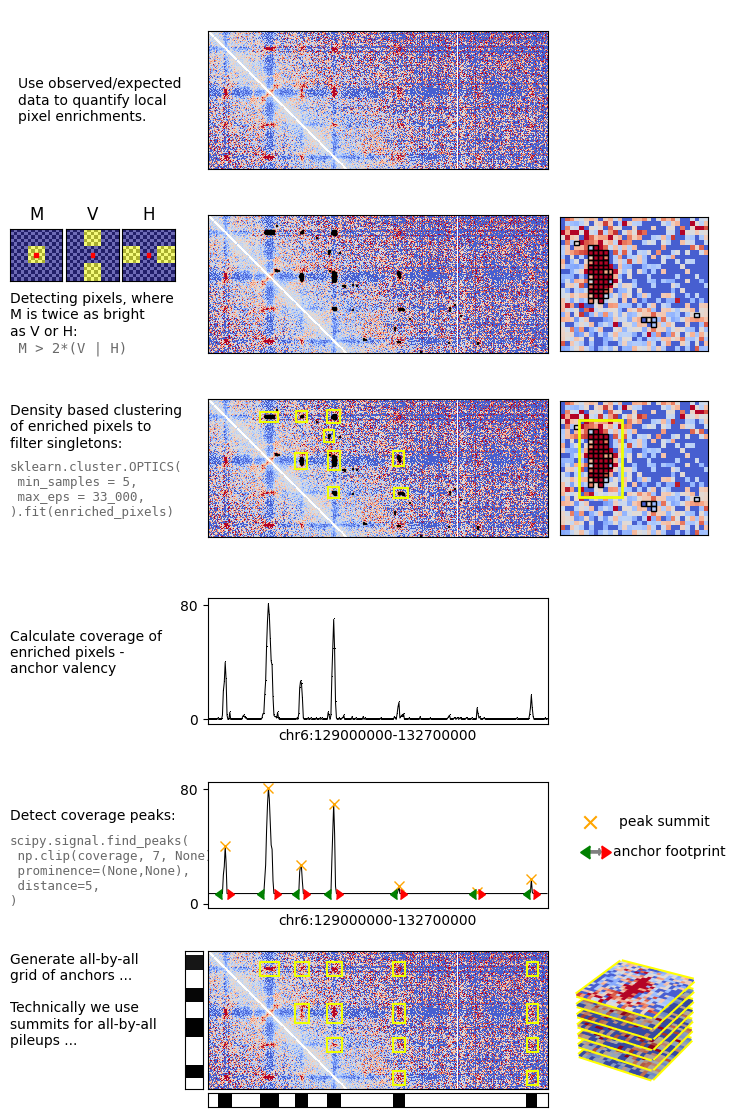

In [21]:


#101820FF
_pixel_boxes_kwargs = dict(loc="upper", lw=1, ec="black", fc="black")
# _pixel_boxes_kwargs = dict(loc="upper", lw=1, ec="#EDFF00FF", fc="#EDFF00FF")
_big_boxes_kwargs = dict(loc="upper", lw=1.5, ec="#EDFF00FF", fc="none", halo=0, ext_width=4)



# Start with a square Figure.
fig = plt.figure(figsize=(7.25, 11), layout="none", facecolor="none")

# make like 6 subfigure on top of each other ...
subfigs = fig.subfigures(6, 3, hspace=0.025, wspace=0.05, width_ratios=[1,1.6,0.7])


#################################################
f1 = subfigs[0,0]
# f1.set_facecolor("blue")
ax = f1.add_subplot(1, 1, 1)
ax.set_axis_off()
ax.text(
    .05,
    .5,
    """
Use observed/expected
data to quantify local
pixel enrichments.
    """,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center"
)

f1 = subfigs[0, 1]
# f1.set_facecolor("green")
# ax = f1.add_subplot(1, 1, 1)
ax = f1.add_axes([0,0,1,1])
ax.imshow(gOE, **imshow_kwargs)
ax.set_xticks([])
ax.set_yticks([])
####################################################



####################################################
# second step ...
f2 = subfigs[1,0]
# f2.set_facecolor("blue")
k_fig = {"M": k7["mid"], "V": k7["h7"], "H": k7["v7"]}
# ax = f2.add_subplot(1, 1, 1)
spec = f2.add_gridspec(
    ncols=len(k_fig),
    nrows=2,
    height_ratios=[1,0.7],
    wspace=0.07,
    hspace=0.07,
)
# plot rounded kernels
for ii, (ktype, kernel) in enumerate(k_fig.items()):
    ax = f2.add_subplot(spec[0, ii])
    imk = draw_kernel(kernel, ax, kernel_name=ktype, cmap="plasma")
# just below - write some stuff ...
ax = f2.add_subplot(spec[1, :])
ax.set_axis_off()
ax.text(
    .0,
    .7,
    """
Detecting pixels, where
M is twice as bright
as V or H:
    """,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center"
);
ax.text(
    .0,
    .1,
    " M > 2*(V | H)",
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center",
    fontname='Monospace',
    color='dimgrey',
);


f2 = subfigs[1, 1]
# f2.set_facecolor("green")
# ax = f2.add_subplot(1, 1, 1)
ax = f2.add_axes([0,0,1,1])
ax.imshow(gOE, **imshow_kwargs)
ax.set_xticks([])
ax.set_yticks([])
for box in rectangles_around_dots(
    enriched_pixels,
    _the_tile,
    **_pixel_boxes_kwargs,
):
    ax.add_patch(box)

f2 = subfigs[1,2]
# f2.set_facecolor("cyan")
ax = f2.add_axes([0,0,1,1])
ax.imshow(gOE_zoom, **imshow_kwargs)
ax.set_xticks([])
ax.set_yticks([])
for box in rectangles_around_dots(
    enriched_pixels,
    _the_tile_zoom,
    **dict(loc="upper", lw=1, ec="black", fc="none"),
):
    ax.add_patch(box)

####################################################




####################################################
# third step ...
f3 = subfigs[2,0]
ax = f3.add_subplot(1, 1, 1)
ax.set_axis_off()
ax.text(
    .0,
    .8,
    """
Density based clustering
of enriched pixels to
filter singletons:
    """,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center"
)
ax.text(
    .0,
    .35,
    """
sklearn.cluster.OPTICS(
 min_samples = 5,
 max_eps = 33_000,
).fit(enriched_pixels)
    """,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center",
    fontname='Monospace',
    fontsize=9,
    color='dimgrey',
);

f3 = subfigs[2, 1]
# ax = f3.add_subplot(1, 1, 1)
ax = f3.add_axes([0,0,1,1])
ax.imshow(gOE, **imshow_kwargs)
ax.set_xticks([])
ax.set_yticks([])
# draw boxes around clustered pixels ...
for box in rectangles_around_dots_ww(
    clustered_pixels,
    _the_tile,
    **_big_boxes_kwargs,
):
    ax.add_patch(box)
# draw enriched pixels themselves again ...
for box in rectangles_around_dots(
    enriched_pixels,
    _the_tile,
    **_pixel_boxes_kwargs,
):
    ax.add_patch(box)


f3 = subfigs[2,2]
ax = f3.add_axes([0,0,1,1])
# ax.set_axis_off()
# ax.text(
#     .0,
#     .5,
#     """
# Keeping only highlighted pixels
# (in boxes) for further analysis ...
#     """,
#     transform=ax.transAxes,
#     horizontalalignment="left",
#     verticalalignment="center"
# );
# ax = f2.add_axes([0,0,1,1])
ax.imshow(gOE_zoom, **imshow_kwargs)
ax.set_xticks([])
ax.set_yticks([])
for box in rectangles_around_dots(
    enriched_pixels,
    _the_tile_zoom,
    **dict(loc="upper", lw=1, ec="black", fc="none"),
):
    ax.add_patch(box)
# draw boxes around clustered pixels ...
for box in rectangles_around_dots_ww(
    clustered_pixels,
    _the_tile_zoom,
    **dict(loc="upper", lw=2, ec="#EDFF00FF", fc="none", halo=0, ext_width=2),
):
    ax.add_patch(box)
#################################################



#################################################
# fifth step ...
f4 = subfigs[3,0]
ax = f4.add_subplot(1, 1, 1)
ax.set_axis_off()
ax.text(
    .0,
    .5,
    """
Calculate coverage of
enriched pixels -
anchor valency
    """,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center"
)

f4 = subfigs[3, 1]
# ax = f4.add_subplot(1, 1, 1)
ax = f4.add_axes([0,0.1,1,0.7])

# calculate pixels coverage ...
rich_pix_vals = get_bin_coverage(enriched_pixels)
# rich_clust_pix_vals = get_bin_coverage(clustered_pixels)
_from, _to = clr.extent(_region2)
rich_pix_vals_plot = pd.Series(index=np.arange(_from,_to)).add(rich_pix_vals.loc[_from: _to], fill_value=0)
# rich_clust_pix_vals_plot = pd.Series(index=np.arange(_from,_to)).add(rich_clust_pix_vals.loc[_from: _to], fill_value=0)

ax.plot(rich_pix_vals_plot.fillna(0), marker=",", markersize=2, lw=0.75, label="all enriched pixels", color="black")
# ax.plot(rich_clust_pix_vals_plot, marker=".", lw=0.5, label="all enriched pixels (w/o singletons)")
# ax.axhline(_val_thresh, color="red")
ax.set_xlim(_from, _to)
ax.set_ylim(-3,85)
ax.set_yticks([0,80])
ax.set_xticks([])
ax.set_xlabel(bioframe.to_ucsc_string(_region2))
# ax.set_yscale("log")
# ax.legend(frameon=False)
# ax.set_aspect(90)
# ax.imshow(gOE, **imshow_kwargs)
# ax.set_xticks([])
# ax.set_yticks([])
####################################################





#################################################
f5 = subfigs[4,0]
ax = f5.add_subplot(1, 1, 1)
ax.set_axis_off()
ax.text(
    .0,
    .65,
    """
Detect coverage peaks:
    """,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center"
)
ax.text(
    .0,
    .25,
    """
scipy.signal.find_peaks(
 np.clip(coverage, 7, None),
 prominence=(None,None),
 distance=5,
)
    """,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center",
    fontname='Monospace',
    fontsize=9,
    color='dimgrey',
);


f5 = subfigs[4, 1]
ax = f5.add_axes([0,0.1,1,0.7])

# # take empty bins and fill non-zero coverage with rich_clust_pix_vals ...
# # use value threshold to define the "floor" of the pixel coverage ...
_val_thresh = 7
_bins = clr.bins()[:]
_bins.index.name = "bin"
_bins["cov"] = rich_pix_vals
_bins["cov"] = _bins["cov"].fillna(0)
_arr = _bins["cov"].to_numpy()

# detect praks on the coverage track ...
_peaks, _props = find_peaks(
    np.clip(_arr, _val_thresh, None),
    prominence=(None,None),
    distance=5,
)

# extract left/right boundaries of every peak ...
_lefts = _props["left_bases"]
_rights = _props["right_bases"]
_arr_clipped = np.clip(_arr, _val_thresh, None)

ax.plot(_arr_clipped[_from: _to], color="black", lw=0.75)
ax.plot(_peaks - _from, _arr_clipped[_peaks], marker="x", lw=0, markersize=7, color="orange")
ax.plot(_lefts - _from, _arr_clipped[_lefts], marker=8, lw=0, markersize=7, color="green" )
ax.plot(_rights - _from, _arr_clipped[_rights], marker=9, lw=0, markersize=7, color="red" )
ax.set_xlim(0, _to-_from )

ax.set_ylim(-3,85)
ax.set_yticks([0,80])
ax.set_xticks([])
ax.set_xlabel(bioframe.to_ucsc_string(_region2))

f5 = subfigs[4, 2]
ax = f5.add_subplot(1, 1, 1)
ax.set_axis_off()

x_foot = 0.05
x_summit = 0.1
y_foot = 0.37
y_summit = 0.63
_radius = 0.05
_dist = 0.2
x_left = x_foot

# ax.add_patch(patches.Circle((x_foot, y_foot), radius=0.05, color="green"))
# ax.add_patch(patches.Circle((x_foot+_dist, y_foot), radius=0.05, color="red"))
ax.add_patch(patches.Arrow(x_foot+_radius, y_foot, _dist-2*_radius, 0, color="grey", width=0.1))
ax.scatter(x=[x_foot+0.05], y=[y_foot], s=80, marker=8, linewidths=1.5, color="green")
ax.scatter(x=[x_foot+_dist-0.05], y=[y_foot], s=80, marker=9, linewidths=1.5, color="red")
# ax.scatter(x=[x_summit], y=[y_summit], s=80, marker="x", linewidths=1.5, color="orange")

ax.text(
    x=x_left+0.25,
    y=y_foot,
    s="anchor footprint",
    horizontalalignment="left",
    verticalalignment="center"
)

ax.scatter(x=[x_summit], y=[y_summit], s=80, marker="x", linewidths=1.5, color="orange")
ax.text(
    x=x_summit+0.25,
    y=y_summit,
    s="peak summit",
    horizontalalignment="left",
    verticalalignment="center"
)
ax.set_aspect(1)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
####################################################



####################################################
# third step ...
f6 = subfigs[5,0]
ax = f6.add_subplot(1, 1, 1)
ax.set_axis_off()
ax.text(
    .0,
    .65,
    """
Generate all-by-all
grid of anchors ...

Technically we use
summits for all-by-all
pileups ...
    """,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center"
)

f6 = subfigs[5, 1]
# ax = f6.add_subplot(1, 1, 1)
ax = f6.add_axes([0,0,1,1])
ax.imshow(gOE, **imshow_kwargs)

# bounds yields (x0, y0, width, height)
x0, y0, dx, dy = ax.get_position().bounds
# get figure bounds ...
_, _, _h, _w = f6.figbbox.bounds
awidth = 0.08
aoffset = 0.02

ax_x = f6.add_axes([x0, y0-awidth-aoffset, dx, awidth])
ax_y = f6.add_axes([x0-(awidth+aoffset)*(_h/_w), y0, awidth*(_h/_w), dy])

_reg2w = np.diff(clr.extent(_region2)).item()
_reg1w = np.diff(clr.extent(_region1)).item()
ax_x.set_xlim(0, _reg2w)
ax_y.set_ylim(0, _reg1w)

ax.set_xticks([])
ax.set_yticks([])
ax_x.set_xticks([])
ax_x.set_yticks([])
ax_y.set_xticks([])
ax_y.set_yticks([])

# draw boxes around clustered pixels ...
for box in rectangles_around_dots_ww(
    _bedpe_region,
    _the_tile,
    **_big_boxes_kwargs,
):
    ax.add_patch(box)
    x0, y0, dx, dy = box.get_bbox().bounds
    ax_x.axvspan(x0, x0+dx, facecolor='black', alpha=0.7)
    ax_x.axvspan(y0, y0+dy, facecolor='black', alpha=0.7)
    ax_y.axhspan(y0, y0+dy, facecolor='black', alpha=0.7)



f6 = subfigs[5,2]
# ax = f6.add_subplot(1, 1, 1)
# ax.set_axis_off()
# ax.text(
#     .0,
#     .5,
#     """
# Consider adding
# a pileups z-stack here -
# for illustration and fun !
#     """,
#     transform=ax.transAxes,
#     horizontalalignment="left",
#     verticalalignment="center"
# );

# stack = np.random.random((100,21,21))
stack = ttt
ooe_norm = TwoSlopeNorm(vcenter=1, vmin=-0.1, vmax=3)
# create a 21 x 21 vertex mesh
*_, dimens = stack.shape
X, Y = np.meshgrid(np.linspace(0,1,dimens), np.linspace(0,1,dimens))
# create vertices for a rotated mesh (3D rotation matrix)
Z =  np.zeros_like(X)

# show the 3D rotated projection
ax = f6.add_subplot(1,1,1,projection='3d')
num_to_show = 6
for i, _matrix in enumerate( stack ):
    if i > num_to_show:
        break
    is_top_element = i!=num_to_show
    # get the heatmap for the region
    ax.plot_wireframe(X, Y, Z+i/num_to_show, linewidths=4, rstride=1, cstride=1,color="yellow")
    ax.plot_surface(
        X,
        Y,
        Z+i/num_to_show,
        rstride=1,
        cstride=1,
        facecolors=mpl.colormaps["coolwarm"](ooe_norm(_matrix)),
        shade=is_top_element,
    )
ax.set_axis_off()
ax.set_position([0,0,1,1])
# ax.set_title("stack of OOE snippets")
# ## Set up plotting parameters:
# axs["up"].spines['right'].set_visible(False)
# axs["up"].spines['top'].set_visible(False)
# # colorbar:
# divider = make_axes_locatable(axs["up"])
# cax = divider.append_axes("right", size="3%", pad=0.1, aspect=6)
# plt.colorbar(im, cax=cax)
#################################################

fig.savefig("id_detection_supplement.pdf", dpi=300)

In [22]:
# _the_dots.sort_values(by=["chrom1", "start1", "start2"]).reset_index(drop=True)

In [199]:
# Calculate domain defining dots ...

_region1 = ('chr7', 38_000_000, 38_000_000+12_500_000)
_region2 = ('chr7', 38_000_000, 38_000_000+12_500_000)
_region1 = ('chr7', 20_500_000, 20_500_000+12_500_000)
_region2 = ('chr7', 20_500_000, 20_500_000+12_500_000)

# _domains = bioframe.merge(
#     # pre-filter super long range dots, as they include translocations ...
#     _the_dots.query("end2 - end1 <= 6_500_000"),
#     # merge "touching" domains or not ...
#     min_dist = None,
#     # outermost: start1->end2, innermost: end1->start2
#     cols = ("chrom1", "start1", "end2")
# )

_the_dots_filtered = _the_dots.query("end2 - end1 <= 3_500_000").reset_index(drop=True)

_index = bioframe.cluster(
    _the_dots_filtered,
    min_dist=21_000,
    cols=("chrom1", "start1", "end1"),
    return_input=True,
    return_cluster_ids=True,
).groupby("cluster")["start2"].idxmax()

_domains = merge_nested(
    # pre-filter super long range dots, as they include translocations ...
    _the_dots_filtered.loc[_index],
    # _the_dots_filtered, #.loc[_index],
    # merge "touching" domains or not ...
    stickout_dist=21_000,
    # outermost: start1->end2, innermost: end1->start2
    cols = ("chrom1", "start1", "end2"),
)


_domains_region = \
_domains.eval("""
    chrom2 = chrom1
    end1 = start1 + 10_000
    start2 = end2 - 10_000
""")[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'n_intervals']]



_domains_region = bioframe.select(
    bioframe.select(
        _domains_region,
        _region1,
        cols=("chrom1","start1","end1")
    ),
    _region2,
    cols=("chrom2","start2","end2"),
).reset_index(drop=True)


_domains_region["bin1_id"] = _domains_region[["chrom1","start1","end1"]].apply(clr.offset,axis=1,result_type="expand")
_domains_region["bin1_width"] = _domains_region[["chrom1","start1","end1"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]

_domains_region["bin2_id"] = _domains_region[["chrom2","start2","end2"]].apply(clr.offset,axis=1,result_type="expand")
_domains_region["bin2_width"] = _domains_region[["chrom2","start2","end2"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]


In [204]:
_domains

,chrom1,start1,end2,n_intervals
0,chr1,980000,1300000,2
1,chr1,1960000,2180000,1
2,chr1,2190000,2550000,1
3,chr1,2410000,3430000,7
4,chr1,3490000,3730000,1
...,...,...,...,...
3091,chr9,136340000,136630000,2
3092,chr9,136790000,137050000,3
3093,chr9,137040000,137530000,4
3094,chr9,137670000,137780000,1


<Axes: >

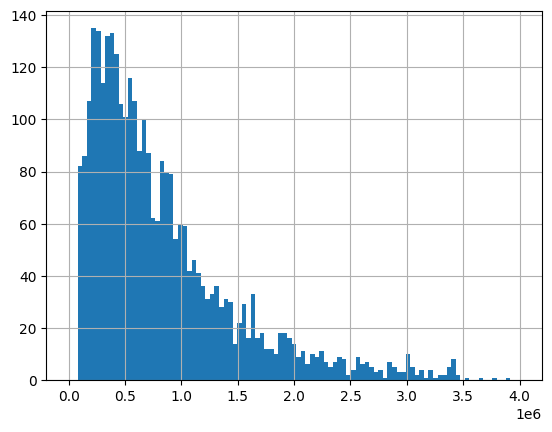

In [203]:
_domains.eval("end2 - start1").hist(bins=np.linspace(0,4_000_000,100))

120 pixels are visible out of 120 ...
174 pixels are visible out of 174 ...
14 pixels are visible out of 14 ...


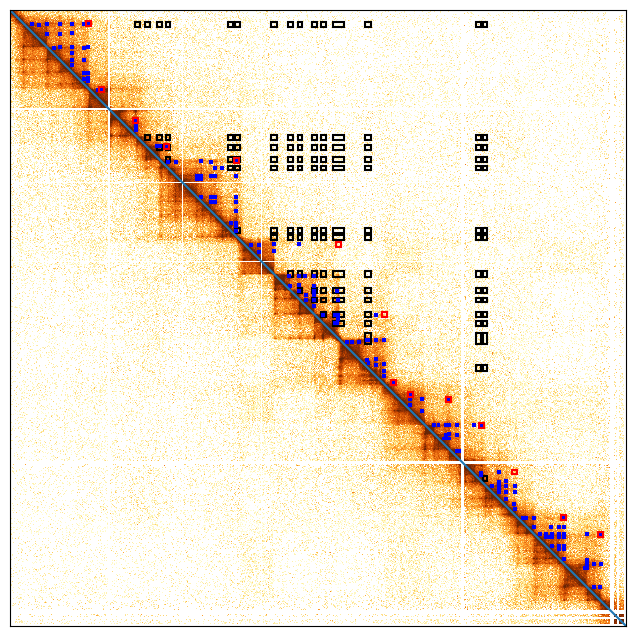

In [198]:
_sample = "m5hR1R2"
clr = telo_clrs[_sample]
exp = telo_exps_cis[_sample]
exp_indexed = exp.set_index(["region1", "region2"])


# _region1 = ('chr7', 22_500_000, 22_500_000+8_500_000)
# _region2 = ('chr7', 22_500_000, 22_500_000+8_500_000)

# _region1 = ('chr7', 25_750_000, 25_750_000+1_570_000)
# _region2 = ('chr7', 25_750_000, 25_750_000+1_570_000)

# _region1 = ('chr6', 129_000_000, 129_000_000+1_500_000)
# _region2 = ('chr6', 129_000_000, 129_000_000+3_700_000)

region1_name = bioframe.select(hg38_arms, _region1).iat[0,-1]
region2_name = bioframe.select(hg38_arms, _region2).iat[0,-1]
assert region1_name == region2_name
region_name = region2_name

tile_span_i = clr.extent(_region1)
tile_span_j = clr.extent(_region2)
_the_tile = (region_name, tile_span_i, tile_span_j )

tile_start_ij = (tile_span_i[0], tile_span_j[0])
lazy_exp = LazyToeplitz(
    exp_indexed.loc[region_name, region_name]["balanced.avg"].to_numpy()
)
# RAW observed matrix slice:
observed = clr.matrix()[slice(*tile_span_i), slice(*tile_span_j)]
expected = lazy_exp[slice(*tile_span_i), slice(*tile_span_j)]

# let's figure out slices' coordinates ....
_bins_i = clr.bins()[slice(*tile_span_i)]
_bins_j = clr.bins()[slice(*tile_span_j)]
_chrom_i, _start_i, _end_i = _bins_i.iloc[0]["chrom"], _bins_i.iloc[0]["start"], _bins_i.iloc[-1]["end"]
_chrom_j, _start_j, _end_j = _bins_j.iloc[0]["chrom"], _bins_j.iloc[0]["start"], _bins_j.iloc[-1]["end"]


gOE = scipy.ndimage.gaussian_filter(
    observed,
    # (observed/expected),
    sigma=0.4,
    order=0,
    mode='reflect',
    cval=0.0,
    # radius=3,
    truncate=1.0,
)


_anchors = _anchors5[["chrom","peak_start","peak_end","cluster"]].rename(columns={"peak_start":"start","peak_end":"end"})
_anchors_reg = bioframe.select(_anchors, _region2).reset_index(drop=True)
_anchors_reg["cluster"] = _anchors_reg["cluster"] - _anchors_reg["cluster"].min()
_anchors_reg = calculate_valencies(
    _anchors_reg,   # must be output of bedpe_to_anchors, which in turn is a clustering inside
    clustered_pixels,
    cluster_colname = "cluster",
    valency_colname = "valency",
    bed_cols = ["chrom", "start", "end"],
    bedpe_cols1 = ["chrom1", "start1", "end1"],
    bedpe_cols2 = ["chrom2", "start2", "end2"],
)

# # print(_anchors_reg)
# _anchors_reg = _anchors_reg.query("valency > 1").reset_index(drop=True)
# # _anchors_reg = _anchors_reg.sample(n=10, weights="valency").sort_index()

_bedpe_region = bioframe.pair_by_distance(
    _anchors_reg,
    min_sep=0,
    # max_sep=(_end - _start)+100_000,
    max_sep=(_region2[2] - _region2[1])+100_000_000,
    suffixes=("1","2"),
    keep_order=True,
)
_bedpe_region["bin1_id"] = _bedpe_region[["chrom1","start1","end1"]].apply(clr.offset,axis=1,result_type="expand")
_bedpe_region["bin1_width"] = _bedpe_region[["chrom1","start1","end1"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]

_bedpe_region["bin2_id"] = _bedpe_region[["chrom2","start2","end2"]].apply(clr.offset,axis=1,result_type="expand")
_bedpe_region["bin2_width"] = _bedpe_region[["chrom2","start2","end2"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]


# _the_dots
############
# ...
imshow_kwargs = dict(
        norm=LogNorm(vmin=0.0001, vmax=0.01),
        # norm=TwoSlopeNorm(vcenter=1, vmin=-0.1, vmax=3),
        # norm=MidPointLogNorm(vmin=1/10, vmax=3, midpoint=1),
        # cmap="RdBu_r",
        cmap="YlOrBr",
        interpolation="nearest",
        # interpolation="none",
)


fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(gOE, **imshow_kwargs)
#
# # bounds yields (x0, y0, width, height)
# x0, y0, dx, dy = ax.get_position().bounds
# # get figure bounds ...
# _, _, _h, _w = f6.figbbox.bounds
# awidth = 0.08
# aoffset = 0.02
#
# ax_x = f6.add_axes([x0, y0-awidth-aoffset, dx, awidth])
# ax_y = f6.add_axes([x0-(awidth+aoffset)*(_h/_w), y0, awidth*(_h/_w), dy])

_reg2w = np.diff(clr.extent(_region2)).item()
_reg1w = np.diff(clr.extent(_region1)).item()
ax.set_xlim(0, _reg2w)
ax.set_ylim(_reg1w,0)
ax.plot([0, _reg2w],[0,_reg1w], )

_big_boxes_kwargs = dict(loc="upper", lw=1.5, ec="k", fc="none", halo=0, ext_width=2)


ax.set_xticks([])
ax.set_yticks([])

# draw boxes around clustered pixels ...
for box in rectangles_around_dots_ww(
    _bedpe_region,
    _the_tile,
    **_big_boxes_kwargs,
):
    ax.add_patch(box)

_the_dots_region = bioframe.select(
    bioframe.select(_the_dots, _region1, cols=("chrom1","start1","end1")),
    _region2,
    cols=("chrom2","start2","end2"),
)
_the_dots_region["bin1_id"] = _the_dots_region[["chrom1","start1","end1"]].apply(clr.offset,axis=1,result_type="expand")
_the_dots_region["bin1_width"] = _the_dots_region[["chrom1","start1","end1"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]

_the_dots_region["bin2_id"] = _the_dots_region[["chrom2","start2","end2"]].apply(clr.offset,axis=1,result_type="expand")
_the_dots_region["bin2_width"] = _the_dots_region[["chrom2","start2","end2"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]


_big_boxes_kwargs = dict(loc="upper", lw=1.5, ec="blue", fc="none", halo=0, ext_width=1)
# draw boxes around clustered pixels ...
i = 1
for box in rectangles_around_dots_ww(
    _the_dots_region,
    _the_tile,
    **_big_boxes_kwargs,
):
    ax.add_patch(box)
    x,y = box.get_center()
    # ax.annotate(f"{i}", (x-.99999,y+.9999), fontsize=15)
    # i += 1

_big_boxes_kwargs = dict(loc="upper", lw=1.5, ec="red", fc="none", halo=0, ext_width=4)
# draw boxes around clustered pixels ...
# i = 1
for box in rectangles_around_dots_ww(
    _domains_region,
    _the_tile,
    **_big_boxes_kwargs,
):
    ax.add_patch(box)
    x,y = box.get_center()
    # ax.annotate(f"{i}", (x-.99999,y+.9999), fontsize=15)
    # i += 1


In [175]:
_the_dots_region.reset_index(drop=True)

,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,...,la_exp.horizontal.qval,la_exp.lowleft.qval,cstart1,cstart2,c_label,c_size,bin1_id,bin1_width,bin2_id,bin2_width
0,chr7,25890000,25900000,chr7,26160000,26170000,180,35.642778,36.778103,51.224417,...,1.314178e-30,1.193030e-42,2.589167e+07,2.617000e+07,274,12,125792,1,125819,1
1,chr7,25890000,25900000,chr7,26360000,26370000,244,26.947186,30.957571,33.811771,...,3.690172e-101,3.064243e-101,2.588889e+07,2.635333e+07,275,9,125792,1,125839,1
2,chr7,25890000,25900000,chr7,26490000,26500000,36,13.536792,11.992135,16.300080,...,4.041792e-02,1.313077e-03,2.589000e+07,2.649000e+07,277,1,125792,1,125852,1
3,chr7,25890000,25900000,chr7,26660000,26670000,70,12.732747,13.991049,15.041533,...,5.782722e-20,2.780611e-25,2.588500e+07,2.666000e+07,276,6,125792,1,125869,1
4,chr7,26080000,26090000,chr7,26360000,26370000,128,24.381885,35.218894,24.247557,...,4.519568e-44,8.995690e-35,2.608500e+07,2.635500e+07,279,4,125811,1,125839,1
5,chr7,26090000,26100000,chr7,26180000,26190000,174,67.790193,42.686206,60.240262,...,5.550418e-28,5.781247e-10,2.608500e+07,2.618000e+07,278,2,125812,1,125821,1
6,chr7,26090000,26100000,chr7,26660000,26670000,32,10.411835,14.873436,9.455746,...,2.514664e-05,1.989361e-05,2.608500e+07,2.666500e+07,280,4,125812,1,125869,1
7,chr7,26190000,26200000,chr7,27140000,27150000,20,5.794460,6.685305,6.682721,...,6.495195e-02,8.847717e-03,2.619000e+07,2.714000e+07,288,1,125822,1,125917,1
8,chr7,26200000,26210000,chr7,26360000,26370000,138,45.508061,59.953639,44.198878,...,5.348558e-22,6.113109e-08,2.620000e+07,2.635286e+07,281,7,125823,1,125839,1
9,chr7,26200000,26210000,chr7,26660000,26670000,42,14.409317,21.603761,11.790998,...,5.917975e-08,1.005917e-05,2.619000e+07,2.666333e+07,282,3,125823,1,125869,1


# x,y = box.get_center()

In [95]:
def rectangles_around_dots_ww_annotate(
    dots_bins_df,
    the_tile,
    loc="upper",
    lw=1,
    ec="cyan",
    fc="none",
    halo=30_000,
    ext_width=0
):
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # parse the tile
    _, tspan1, tspan2 = the_tile
    # select only visible "boxes" :
    _the_dots = dots_bins_df \
        .query("""(@tspan1[0] - @halo < bin1_id < @tspan1[1] + @halo) & \
                  (@tspan2[0] - @halo < bin2_id < @tspan2[1] + @halo) """) \
        .eval("""
                b1 = bin1_id - @tspan1[0] - @ext_width - 0.5
                b2 = bin2_id - @tspan2[0] - @ext_width - 0.5
                bin1_width = bin1_width + 2*@ext_width
                bin2_width = bin2_width + 2*@ext_width
            """)
    print(f"{len(_the_dots)} pixels are visible out of {len(dots_bins_df)} ...")
    for i, b1, b2, w1, w2 in _the_dots[["b1", "b2", "bin1_width", "bin2_width"]].reset_index(drop=True).itertuples():
        if loc == "upper":
            yield patches.Rectangle((b2, b1), w2+1, w1+1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((b1, b2), w1+1, w2+1, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

Signature:
rectangles_around_dots_ww(
    dots_bins_df,
    the_tile,
    loc='upper',
    lw=1,
    ec='cyan',
    fc='none',
    halo=30000,
    ext_width=0,
)
Docstring: <no docstring>
Source:   
def rectangles_around_dots_ww(dots_bins_df, the_tile, loc="upper", lw=1, ec="cyan", fc="none", halo=30_000, ext_width=0):
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # parse the tile
    _, tspan1, tspan2 = the_tile
    # select only visible "boxes" :
    _the_dots = dots_bins_df \
        .query("""(@tspan1[0] - @halo < bin1_id < @tspan1[1] + @halo) & \
                  (@tspan2[0] - @halo < bin2_id < @tspan2[1] + @halo) """) \
        .eval("""
                b1 = bin1_id - @tspan1[0] - @ext_width - 0.5
                b2 = bin2_id - @tspan2[0] - @ext_width - 0.5
                bin1_width = bin1_width + 2*@ext_width
                bin2_width = bin2_width + 2*@ext_width
            """)
    print(f"{len(_the_dots)} pixels are visible out of {len(dots_bins_df)} ...")
    for b1

In [152]:
bioframe.sort_bedframe(
    _the_dots,
    view_df=hg38_arms,
    cols=("chrom1","start1","start2")
)

,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,...,la_exp.donut.qval,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,cstart1,cstart2,c_label,c_size,bin1_id,bin1_width
0,chr1,980000,990000,chr1,1230000,1240000,84,43.992606,47.102878,46.997057,...,2.685787e-04,2.863351e-04,2.837450e-04,6.628075e-08,9.800000e+05,1.230000e+06,0,1,98,1
1,chr1,980000,990000,chr1,1290000,1300000,52,25.092082,27.924011,28.013767,...,1.698389e-04,1.910882e-02,1.872793e-02,1.596149e-02,9.800000e+05,1.290000e+06,1,1,98,1
2,chr1,1120000,1130000,chr1,1230000,1240000,462,150.384865,189.013001,173.986246,...,3.441099e-81,1.769679e-53,1.919847e-53,4.561214e-81,1.120000e+06,1.233333e+06,2,12,112,1
3,chr1,1120000,1130000,chr1,1290000,1300000,136,58.133833,56.578425,96.260505,...,1.160096e-13,1.409601e-13,4.619922e-03,1.202640e-13,1.120000e+06,1.290000e+06,3,1,112,1
4,chr1,1950000,1960000,chr1,2040000,2050000,577,254.236330,196.896038,182.393181,...,4.646874e-65,3.632724e-100,4.215936e-100,2.638754e-14,1.934000e+06,2.038000e+06,4,5,195,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27368,chr22,49930000,49940000,chr22,50030000,50040000,570,157.615469,205.033101,179.961548,...,1.559315e-135,8.246221e-63,5.703830e-97,2.696230e-96,4.992286e+07,5.002857e+07,380,7,287420,1
27369,chr22,49930000,49940000,chr22,50200000,50210000,148,41.791118,45.192435,50.457158,...,1.332710e-26,2.022408e-26,1.953275e-26,1.581702e-26,4.992667e+07,5.019833e+07,382,6,287420,1
27370,chr22,50240000,50250000,chr22,50340000,50350000,228,102.379154,108.891521,110.069954,...,1.622066e-14,1.130048e-14,1.135683e-14,1.899326e-14,5.024000e+07,5.034000e+07,384,1,287451,1
27371,chr22,50250000,50260000,chr22,50430000,50440000,184,73.177778,65.163972,107.067364,...,1.421811e-21,1.641049e-21,1.317740e-05,1.742365e-32,5.024333e+07,5.043833e+07,383,6,287452,1


,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,...,la_exp.donut.qval,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,cstart1,cstart2,c_label,c_size,bin1_id,bin1_width
0,chr10,170000,180000,chr10,500000,510000,51,25.523554,25.916025,28.834911,...,3.084019e-02,2.946363e-02,2.895734e-02,2.441395e-02,1.733333e+05,5.033333e+05,0,3,167509,1
1,chr10,170000,180000,chr10,770000,780000,50,19.948992,21.730414,23.870302,...,2.469265e-06,6.860013e-04,6.436951e-04,3.485254e-09,1.700000e+05,7.700000e+05,1,1,167509,1
2,chr10,500000,510000,chr10,780000,790000,183,61.454183,68.569727,78.027477,...,4.261171e-32,3.704002e-21,3.587212e-21,4.946070e-32,5.060000e+05,7.840000e+05,2,10,167542,1
3,chr10,510000,520000,chr10,650000,660000,164,80.269141,77.580929,99.086801,...,6.239024e-15,6.812323e-15,8.521756e-08,6.156771e-15,5.066667e+05,6.666667e+05,3,3,167543,1
4,chr10,1110000,1120000,chr10,3040000,3050000,27,10.484797,12.152963,9.667174,...,3.881979e-02,3.528207e-02,2.839917e-03,2.754586e-02,1.110000e+06,3.040000e+06,4,1,167603,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27368,chr9,137290000,137300000,chr9,137520000,137530000,85,33.010499,32.893258,41.959347,...,3.069382e-08,3.639069e-08,1.734407e-04,3.230365e-08,1.372833e+08,1.375250e+08,887,6,167381,1
27369,chr9,137290000,137300000,chr9,137400000,137410000,428,117.894193,136.808648,127.766343,...,1.085209e-94,1.426449e-66,8.196886e-95,4.181408e-66,1.372910e+08,1.374070e+08,888,10,167381,1
27370,chr9,137420000,137430000,chr9,137520000,137530000,140,77.268736,85.910580,61.154818,...,2.220707e-08,1.348902e-03,6.610708e-15,1.407912e-03,1.374200e+08,1.375200e+08,889,1,167394,1
27371,chr9,137670000,137680000,chr9,137770000,137780000,151,74.395264,72.644486,78.841849,...,3.556477e-11,3.817004e-11,3.748351e-11,2.687089e-05,1.376700e+08,1.377700e+08,890,1,167419,1


In [65]:
# bioframe.select?

bioframe.select(
    bioframe.select(_the_dots, _region1, cols=("chrom1","start1","end1")),
    _region2,
    cols=("chrom2","start2","end2"),
)

,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,...,la_exp.donut.qval,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,cstart1,cstart2,c_label,c_size,bin1_id,bin1_width
22711,chr6,127190000,127200000,chr6,127540000,127550000,32,12.404561,15.981994,10.740123,...,9.761174e-04,2.253812e-02,1.005040e-03,1.734726e-02,127190000.0,1.275400e+08,559,1,118841,1
22712,chr6,127300000,127310000,chr6,127540000,127550000,93,20.554229,28.896871,23.002844,...,1.748907e-22,3.435656e-16,2.785214e-22,2.580311e-16,127300000.0,1.275329e+08,560,7,118852,1
22713,chr6,127300000,127310000,chr6,127460000,127470000,108,41.511989,40.821681,55.990561,...,8.920116e-11,1.078320e-10,6.846991e-06,9.028297e-11,127300000.0,1.274400e+08,561,3,118852,1
22714,chr6,127440000,127450000,chr6,127540000,127550000,107,58.221540,72.986321,47.114228,...,1.040508e-05,2.381148e-02,2.200245e-10,2.003741e-02,127440000.0,1.275400e+08,562,1,118866,1
22715,chr6,127460000,127470000,chr6,127640000,127650000,59,26.381209,26.215452,36.270866,...,5.182327e-04,5.324497e-04,5.643294e-02,8.321257e-07,127460000.0,1.276400e+08,563,1,118868,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22805,chr6,134170000,134180000,chr6,134440000,134450000,109,48.103313,40.188865,71.294356,...,4.199470e-11,4.563762e-17,1.322853e-02,3.444862e-06,134170000.0,1.344450e+08,653,2,119539,1
22806,chr6,134170000,134180000,chr6,134530000,134540000,150,44.100693,41.699422,68.666901,...,1.574971e-27,2.432674e-27,6.958033e-11,1.898656e-27,134172500.0,1.345225e+08,654,4,119539,1
22807,chr6,134170000,134180000,chr6,134880000,134890000,201,80.757069,86.969635,99.333071,...,4.158063e-17,4.186165e-17,3.970603e-17,1.368919e-54,134170000.0,1.348800e+08,655,2,119539,1
22808,chr6,134160000,134170000,chr6,134930000,134940000,126,57.817544,73.604546,81.804058,...,1.398505e-10,2.377534e-05,6.187847e-02,6.346283e-25,134170000.0,1.349350e+08,656,4,119538,1


In [61]:
rectangles_around_dots_ww??

Signature:
rectangles_around_dots_ww(
    dots_bins_df,
    the_tile,
    loc='upper',
    lw=1,
    ec='cyan',
    fc='none',
    halo=30000,
    ext_width=0,
)
Docstring: <no docstring>
Source:   
def rectangles_around_dots_ww(dots_bins_df, the_tile, loc="upper", lw=1, ec="cyan", fc="none", halo=30_000, ext_width=0):
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # parse the tile
    _, tspan1, tspan2 = the_tile
    # select only visible "boxes" :
    _the_dots = dots_bins_df \
        .query("""(@tspan1[0] - @halo < bin1_id < @tspan1[1] + @halo) & \
                  (@tspan2[0] - @halo < bin2_id < @tspan2[1] + @halo) """) \
        .eval("""
                b1 = bin1_id - @tspan1[0] - @ext_width - 0.5
                b2 = bin2_id - @tspan2[0] - @ext_width - 0.5
                bin1_width = bin1_width + 2*@ext_width
                bin2_width = bin2_width + 2*@ext_width
            """)
    print(f"{len(_the_dots)} pixels are visible out of {len(dots_bins_df)} ...")
    for b1

In [59]:
# _the_dots
# _the_dots["bin1_id"] = _the_dots[["chrom1","start1","end1"]].apply(clr.offset,axis=1,result_type="expand")
# _the_dots["bin1_width"] = _the_dots[["chrom1","start1","end1"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]

# _the_dots["bin2_id"] = _the_dots[["chrom2","start2","end2"]].apply(clr.offset,axis=1,result_type="expand")
# _the_dots["bin2_width"] = _the_dots[["chrom2","start2","end2"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]




,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,la_exp.lowleft.value,la_exp.donut.qval,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,cstart1,cstart2,c_label,c_size
0,chr10,170000,180000,chr10,500000,510000,51,25.523554,25.916025,28.834911,27.313944,3.084019e-02,2.946363e-02,2.895734e-02,2.441395e-02,1.733333e+05,5.033333e+05,0,3
1,chr10,170000,180000,chr10,770000,780000,50,19.948992,21.730414,23.870302,15.015863,2.469265e-06,6.860013e-04,6.436951e-04,3.485254e-09,1.700000e+05,7.700000e+05,1,1
2,chr10,500000,510000,chr10,780000,790000,183,61.454183,68.569727,78.027477,61.611239,4.261171e-32,3.704002e-21,3.587212e-21,4.946070e-32,5.060000e+05,7.840000e+05,2,10
3,chr10,510000,520000,chr10,650000,660000,164,80.269141,77.580929,99.086801,77.999957,6.239024e-15,6.812323e-15,8.521756e-08,6.156771e-15,5.066667e+05,6.666667e+05,3,3
4,chr10,1110000,1120000,chr10,3040000,3050000,27,10.484797,12.152963,9.667174,10.369573,3.881979e-02,3.528207e-02,2.839917e-03,2.754586e-02,1.110000e+06,3.040000e+06,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27368,chr9,137290000,137300000,chr9,137520000,137530000,85,33.010499,32.893258,41.959347,33.406702,3.069382e-08,3.639069e-08,1.734407e-04,3.230365e-08,1.372833e+08,1.375250e+08,887,6
27369,chr9,137290000,137300000,chr9,137400000,137410000,428,117.894193,136.808648,127.766343,130.651241,1.085209e-94,1.426449e-66,8.196886e-95,4.181408e-66,1.372910e+08,1.374070e+08,888,10
27370,chr9,137420000,137430000,chr9,137520000,137530000,140,77.268736,85.910580,61.154818,94.887504,2.220707e-08,1.348902e-03,6.610708e-15,1.407912e-03,1.374200e+08,1.375200e+08,889,1
27371,chr9,137670000,137680000,chr9,137770000,137780000,151,74.395264,72.644486,78.841849,82.709794,3.556477e-11,3.817004e-11,3.748351e-11,2.687089e-05,1.376700e+08,1.377700e+08,890,1


In [ ]:
_bedpe_region["bin1_id"] = _bedpe_region[["chrom1","start1","end1"]].apply(clr.offset,axis=1,result_type="expand")
_bedpe_region["bin1_width"] = _bedpe_region[["chrom1","start1","end1"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]

_bedpe_region["bin2_id"] = _bedpe_region[["chrom2","start2","end2"]].apply(clr.offset,axis=1,result_type="expand")
_bedpe_region["bin2_width"] = _bedpe_region[["chrom2","start2","end2"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]




# Some drawing functions ...

In [114]:
def rectangles_around_dots(dots_bins_df, the_tile, loc="upper", lw=1, ec="cyan", fc="none"):
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # parse the tile
    _, tspan1, tspan2 = the_tile
    # select only visible pixels :
    _the_dots = dots_bins_df \
        .query("""(@tspan1[0] < bin1_id < @tspan1[1]) & \
                  (@tspan2[0] < bin2_id < @tspan2[1]) """) \
        .eval("""b1 = bin1_id - @tspan1[0]
                 b2 = bin2_id - @tspan2[0] """)
    print(f"{len(_the_dots)} pixels are visible out of {len(dots_bins_df)} ...")
    # iterate over visible pixels...
    for b1, b2 in _the_dots[["b1", "b2"]].itertuples(index=False):
        w1 = w2 = 1
        if loc == "upper":
            yield patches.Rectangle((b2, b1), w2, w1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((b1, b2), w1, w2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots_ww(dots_bins_df, the_tile, loc="upper", lw=1, ec="cyan", fc="none", halo=30_000, ext_width=0):
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # parse the tile
    _, tspan1, tspan2 = the_tile
    # select only visible "boxes" :
    _the_dots = dots_bins_df \
        .query("""(@tspan1[0] - @halo < bin1_id < @tspan1[1] + @halo) & \
                  (@tspan2[0] - @halo < bin2_id < @tspan2[1] + @halo) """) \
        .eval("""
                b1 = bin1_id - @tspan1[0] - @ext_width
                b2 = bin2_id - @tspan2[0] - @ext_width
                bin1_width = bin1_width + @ext_width
                bin2_width = bin2_width + @ext_width
            """)
    print(f"{len(_the_dots)} pixels are visible out of {len(dots_bins_df)} ...")
    for b1, b2, w1, w2 in _the_dots[["b1", "b2", "bin1_width", "bin2_width"]].itertuples(index=False):
        if loc == "upper":
            yield patches.Rectangle((b2, b1), w2+1, w1+1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((b1, b2), w1+1, w2+1, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

In [115]:
def bedpe_to_anchors(
    bedpe_df,
    view_df,  # for sorting !
    cols1 = ["chrom1", "start1", "end1"],
    cols2 = ["chrom2", "start2", "end2"],
    mode="cluster"
):
    """
    turning bedpe interactions to a bed of anchors - the simple way

    mode - allow for several way to merge upstream and downstream
    anchors. cluster, max_size, max_valency, median
    """
    _cols = ["chrom", "start", "end"]
    _cluster_cols = ["chrom", "cluster_start", "cluster_end"]
    # concat left and right anchors ...
    _bed = pd.concat(
        [
            bedpe_df[cols1].rename(columns={c1:c for c1,c in zip(cols1, _cols)}),
            bedpe_df[cols2].rename(columns={c2:c for c2,c in zip(cols2, _cols)}),
        ],
        ignore_index=True,
    )
    # clustering anchors - define clusters of overlaping anchors ...
    _anchors = bioframe.cluster(
        bioframe.sort_bedframe(_bed, view_df=view_df),
        # min_dist=None,
        min_dist=binsize+1,
        return_input=True,
    ).reset_index(drop=True)
    if mode == "cluster":
        # simply return resulting clusters - i.e. total footprint of clustered anchors ...
        _anchors = _anchors.drop_duplicates(subset=_cluster_cols).reset_index(drop=True)
        # calculate size just in case
        _anchors["size"] = _anchors[_cluster_cols[2]] - _anchors[_cluster_cols[1]]
        # return _anchors with coordinates rename as needed !
        return _anchors.drop(columns=["start","end"]).rename(columns={"cluster_start":"start", "cluster_end":"end"})
    elif mode == "max_size":
        # return the largest anchor per cluster
        # size of anchors, not clusters !!!
        _anchors["size"] = _anchors[_cols[2]] - _anchors[_cols[1]]
        _largest_anchor_idx = _anchors.groupby("cluster")["size"].idxmax()
        _anchors = _anchors.loc[_largest_anchor_idx]
        # return _anchors - i.e. the largest anchor per cluster of overlaping anchors
        return _anchors.drop(columns=["cluster_start","cluster_end"]).reset_index(drop=True)
    elif mode == "median":
        # return the of start and end coords per cluster of overlaping anchors ...
        _anchors = _anchors.groupby("cluster").agg({"chrom":"first", "start":"median", "end":"median"})
        _anchors = _anchors.reset_index().astype({"start":int, "end":int})
        _anchors["size"] = _anchors[_cols[2]] - _anchors[_cols[1]]
        # return _anchors - i.e. the largest anchor per cluster of overlaping anchors
        return _anchors.reset_index(drop=True)
    else:
        raise ValueError()


def calculate_valencies(
    bed_df,  # must be output of bedpe_to_anchors, which in turn is a clustering inside
    bedpe_df,
    cluster_colname = "cluster",
    valency_colname = "valency",
    bed_cols = ["chrom", "cluster_start", "cluster_end"],
    bedpe_cols1 = ["chrom1", "start1", "end1"],
    bedpe_cols2 = ["chrom2", "start2", "end2"],
):
    """
    calculate valencies of a given anchors, given the bedpe ...
    """

    if cluster_colname not in bed_df.columns:
        raise ValueError("bed_df does not seem to be the result of bedpe_to_anchors/clustering ...")

    # overlap combined anchors with the left anchors to see how many "dots" we overlap ...
    anchors_left = bioframe.overlap(
        bed_df,
        bedpe_df,
        how='left',
        cols1=bed_cols,
        cols2=bedpe_cols1,
    ).dropna( subset=[f"{c}_" for c in bedpe_cols1] )

    # overlap combined anchors with the right anchors to see how many "dots" we overlap ...
    anchors_right = bioframe.overlap(
        bed_df,
        bedpe_df,
        how='left',
        cols1=bed_cols,
        cols2=bedpe_cols2,
    ).dropna( subset=[f"{c}_" for c in bedpe_cols2] )

    _num_clusters = len(bed_df)
    # sanity check here ... - make sure we cover all of the cluster that are available ...
    assert ( bed_df[cluster_colname].sort_values() == np.arange(_num_clusters) ).all()
    # ...
    _empty_clust_series = pd.Series(
        data=np.zeros(_num_clusters),
        index=pd.Index(data=np.arange(_num_clusters), name=cluster_colname),
        name="count"
    )

    # calculate valencies ...
    _valencies = (_empty_clust_series + anchors_left[cluster_colname].value_counts()).fillna(0) \
                + (_empty_clust_series + anchors_right[cluster_colname].value_counts()).fillna(0)

    # assign valencies back to anchors bed_df - carefully !
    # _valencies are indexed using cluster_id - s
    bed_df_clust_indexed = bed_df.set_index(cluster_colname)
    bed_df_clust_indexed[valency_colname] = _valencies.astype(int)
    #
    return bed_df_clust_indexed.reset_index()


# Let's draw an all-by-all grid of IDs ...
... to demonstrate what's being called and what's not ...

In [128]:
_anchors5

,chrom,start,end,cluster,size,valency,peak_start,peak_end,size.1
0,chr1,1020000,1030000,0,30000,3,1010000,1040000,30000
1,chr1,1900000,1910000,1,30000,2,1890000,1920000,30000
2,chr1,6600000,6610000,2,30000,2,6590000,6620000,30000
3,chr1,7770000,7780000,3,30000,2,7760000,7790000,30000
4,chr1,7990000,8000000,4,40000,2,7980000,8020000,40000
...,...,...,...,...,...,...,...,...,...
2100,chr22,45170000,45180000,2100,50000,2,45140000,45190000,50000
2101,chr22,46070000,46080000,2101,130000,11,46020000,46150000,130000
2102,chr22,46750000,46760000,2102,30000,2,46740000,46770000,30000
2103,chr22,49940000,49950000,2103,70000,5,49920000,49990000,70000


### turn anchors into all-by-grid that fits in the region ...

In [189]:

_region1 = ('chr6', 129_000_000, 129_000_000+1_500_000)
_region2 = ('chr6', 129_000_000, 129_000_000+2_700_000)


_anchors = _anchors5[["chrom","peak_start","peak_end","cluster"]].rename(columns={"peak_start":"start","peak_end":"end"})
_anchors_reg = bioframe.select(_anchors, _region2).reset_index(drop=True)
_anchors_reg["cluster"] = _anchors_reg["cluster"] - _anchors_reg["cluster"].min()
_anchors_reg = calculate_valencies(
    _anchors_reg,   # must be output of bedpe_to_anchors, which in turn is a clustering inside
    clustered_pixels,
    cluster_colname = "cluster",
    valency_colname = "valency",
    bed_cols = ["chrom", "start", "end"],
    bedpe_cols1 = ["chrom1", "start1", "end1"],
    bedpe_cols2 = ["chrom2", "start2", "end2"],
)

# # print(_anchors_reg)
# _anchors_reg = _anchors_reg.query("valency > 1").reset_index(drop=True)
# # _anchors_reg = _anchors_reg.sample(n=10, weights="valency").sort_index()

_bedpe_region = bioframe.pair_by_distance(
    _anchors_reg,
    min_sep=0,
    # max_sep=(_end - _start)+100_000,
    max_sep=(_end - _start)+100_000_000,
    suffixes=("1","2"),
    keep_order=True,
)

# now find those all-by-allers that were actually called in the screening procedure ...

_overlap1 = bioframe.overlap(
    _bedpe_region,
    clustered_pixels,
    how='left',
    cols1=["chrom1","start1","end1"],
    cols2=["chrom1","start1","end1"],
    suffixes=('', '_'),
).dropna().set_index(["cluster1","cluster2"])


_overlap2 = bioframe.overlap(
    _bedpe_region,
    clustered_pixels,
    how='left',
    cols1=["chrom2","start2","end2"],
    cols2=["chrom2","start2","end2"],
    suffixes=('', '_'),
).dropna().set_index(["cluster1","cluster2"])


_2d_mask = []
for _c1, _c2 in _bedpe_region[["cluster1","cluster2"]].itertuples(index=False):
    # print(_c1, _c2)
    try:
        _labs1 = _overlap1.loc[(_c1,_c2), "labels_"].to_list()
        _labs2 = _overlap2.loc[(_c1,_c2), "labels_"].to_list()
        _call_overlap = bool(set(_labs1) & set(_labs2))
        _2d_mask.append(_call_overlap)
    except KeyError:
        _2d_mask.append(False)

print(_2d_mask)

[True, True, True, False, True, True, True, True, True, False]


# annotate bedpe region with bins and bin widths ...

In [190]:
_bedpe_region["bin1_id"] = _bedpe_region[["chrom1","start1","end1"]].apply(clr.offset,axis=1,result_type="expand")
_bedpe_region["bin1_width"] = _bedpe_region[["chrom1","start1","end1"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]


_bedpe_region["bin2_id"] = _bedpe_region[["chrom2","start2","end2"]].apply(clr.offset,axis=1,result_type="expand")
_bedpe_region["bin2_width"] = _bedpe_region[["chrom2","start2","end2"]].apply(clr.extent,axis=1,result_type="expand").apply(np.diff,axis=1,result_type="expand")[0]

In [200]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, TwoSlopeNorm

# # https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
# class MidPointLogNorm(LogNorm):
#     def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
#         LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
#         self.midpoint=midpoint
#     def __call__(self, value, clip=None):
#         # I'm ignoring masked values and all kinds of edge cases to make a
#         # simple example...
#         x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
#         return np.ma.masked_array(np.interp(np.log(value), x, y))



# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        vmin, midpoint, vmax = self.vmin, self.midpoint, self.vmax
        x, y = [np.log(vmin), np.log(midpoint), np.log(vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        # t_vmin, t_midpoint, t_vmax = np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)
        vmin, midpoint, vmax = self.vmin, self.midpoint, self.vmax

        x, y = [0, 0.5, 1], [np.log(vmin), np.log(midpoint), np.log(vmax)]
        # # return np.ma.masked_array(np.interp(np.log(value), x, y))
        # if np.iterable(value):
        #     val = np.ma.asarray(value)
        #     return np.ma.power(val, 1. / gamma) * (vmax - vmin) + vmin
        # else:
        # return pow(value, 1. / gamma) * (vmax - vmin) + vmin
        return np.exp(np.interp(value, x, y))



imshow_kwargs = dict(
        # norm=LogNorm(vmin=1/5, vmax=5),
        norm=TwoSlopeNorm(vcenter=1, vmin=-0.1, vmax=3),
        # norm=MidPointLogNorm(vmin=1/10, vmax=3, midpoint=1),
        # cmap="RdBu_r",
        cmap="coolwarm",
        # interpolation="nearest",
        interpolation="none",
)


9 pixels are visible out of 8135 ...
237 pixels are visible out of 167288 ...
9 pixels are visible out of 9413 ...
10 pixels are visible out of 10 ...


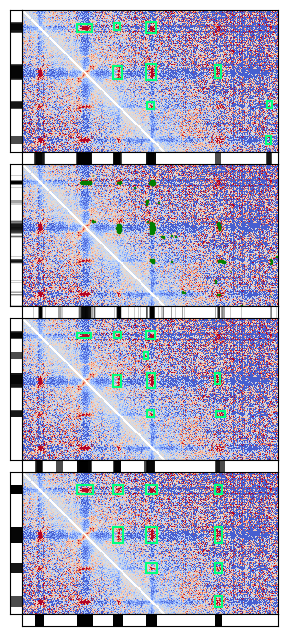

In [203]:
region1_name = bioframe.select(hg38_arms, _region1).iat[0,-1]
region2_name = bioframe.select(hg38_arms, _region2).iat[0,-1]
assert region1_name == region2_name
region_name = region2_name
#
tile_span_i = clr.extent(_region1)
tile_span_j = clr.extent(_region2)
_the_tile = (region_name, tile_span_i, tile_span_j )

tile_start_ij = (tile_span_i[0], tile_span_j[0])
lazy_exp = LazyToeplitz(
    exp_indexed.loc[region_name, region_name]["balanced.avg"].to_numpy()
)
# RAW observed matrix slice:
observed = clr.matrix()[slice(*tile_span_i), slice(*tile_span_j)]
expected = lazy_exp[slice(*tile_span_i), slice(*tile_span_j)]

# let's figure out slices' coordinates ....
_bins_i = clr.bins()[slice(*tile_span_i)]
_bins_j = clr.bins()[slice(*tile_span_j)]
_chrom_i, _start_i, _end_i = _bins_i.iloc[0]["chrom"], _bins_i.iloc[0]["start"], _bins_i.iloc[-1]["end"]
_chrom_j, _start_j, _end_j = _bins_j.iloc[0]["chrom"], _bins_j.iloc[0]["start"], _bins_j.iloc[-1]["end"]


# Start with a square Figure.
fig = plt.figure(figsize=(18, 8))

outer_grid = fig.add_gridspec(4, 1, wspace=0, hspace=0)

ax = fig.add_subplot(outer_grid[0])
axb = fig.add_subplot(outer_grid[1])
axc = fig.add_subplot(outer_grid[2])
axd = fig.add_subplot(outer_grid[3])

divider = make_axes_locatable(ax)
ax_x = divider.append_axes("bottom", size=0.12, pad=0.00, sharex=ax)
ax_y = divider.append_axes("left", size=0.12, pad=0.00, sharey=ax)
# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(axb)
axb_x = divider.append_axes("bottom", size=0.12, pad=0.00, sharex=axb)
axb_y = divider.append_axes("left", size=0.12, pad=0.00, sharey=axb)
# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(axc)
axc_x = divider.append_axes("bottom", size=0.12, pad=0.00, sharex=axc)
axc_y = divider.append_axes("left", size=0.12, pad=0.00, sharey=axc)
# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(axd)
axd_x = divider.append_axes("bottom", size=0.12, pad=0.00, sharex=axd)
axd_y = divider.append_axes("left", size=0.12, pad=0.00, sharey=axd)


gOE = scipy.ndimage.gaussian_filter(
    (observed/expected),
    sigma=0.4,
    order=0,
    mode='reflect',
    cval=0.0,
    # radius=3,
    truncate=1.0,
)


hm_axes = [ax, axb, axc, axd]
x_axes = [ax_x, axb_x, axc_x, axd_x]
y_axes = [ax_y, axb_y, axc_y, axd_y]
_boxes_to_draw = [clustered_pixels_old, enriched_pixels, clustered_pixels, _bedpe_region]
_boxes_type = ["box", "pixel", "box", "box"]
_alphas = [0.7, 0.2, 0.7, 0.7]

for _ax, _axx, _axy, _bt, _boxes, _alpha in zip(
    hm_axes,
    x_axes,
    y_axes,
    _boxes_type,
    _boxes_to_draw,
    _alphas,
):
    #
    _ax.imshow(
        # (observed/expected),
        gOE,
        **imshow_kwargs,
    )
    # ...
    if _bt == "pixel":
        _draw_boxes = rectangles_around_dots
        _boxes_kwargs = dict(loc="upper", lw=1, ec="green", fc="green")
    else:
        _draw_boxes = rectangles_around_dots_ww
        _boxes_kwargs = dict(loc="upper", lw=1.5, ec="springgreen", fc="none", halo=0, ext_width=3)
    # ...
    for box in _draw_boxes(
        _boxes,
        _the_tile,
        **_boxes_kwargs,
    ):
        _ax.add_patch(box)
        x0, y0, dx, dy = box.get_bbox().bounds
        _axx.axvspan(x0, x0+dx, facecolor='black', alpha=_alpha)
        _axx.axvspan(y0, y0+dy, facecolor='black', alpha=_alpha)
        _axy.axhspan(y0, y0+dy, facecolor='black', alpha=_alpha)
        # _axy.axhspan(x0, x0+dx, facecolor='black', alpha=_alpha)
        ########################################################
    _ax.set_xticks([])
    _ax.set_yticks([])
    _axx.set_xticks([])
    _axx.set_yticks([])
    _axy.set_xticks([])
    _axy.set_yticks([])


plt.savefig("grid_csh_coolwarm_600.pdf",dpi=600)

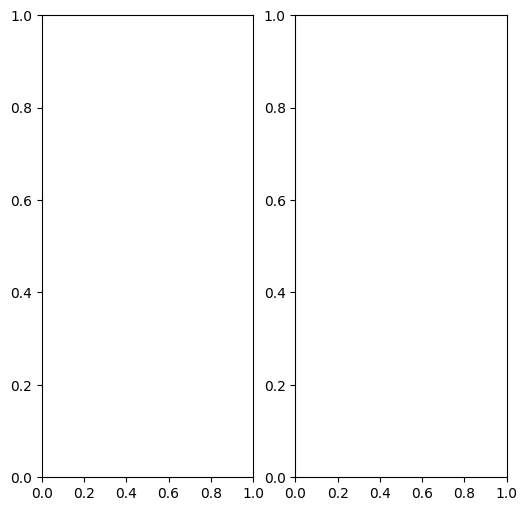

In [194]:


# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# fig = plt.figure()
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot

ax = fig.add_subplot(1, 2, 1)

# # ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
# # gs = fig.add_gridspec(2, 2,  width_ratios=(1, 10), height_ratios=(10, 1),
# #                       left=0.1, right=0.9, bottom=0.1, top=0.9,
# #                       wspace=0.02, hspace=0.02)
# ax_histy = fig.add_subplot(gs[0, 0], sharey=ax)
# ax_histx = fig.add_subplot(gs[1, 1], sharex=ax)
# ax_histy = ax.inset_axes([0, 0, 1, 0.25], sharex=ax)
# ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)

ax = fig.add_subplot(1, 2, 2)


NameError: name 'xxx' is not defined

/data/sergpolly/localenv/lib/python3.10/site-packages/numpy/ma/core.py:858: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


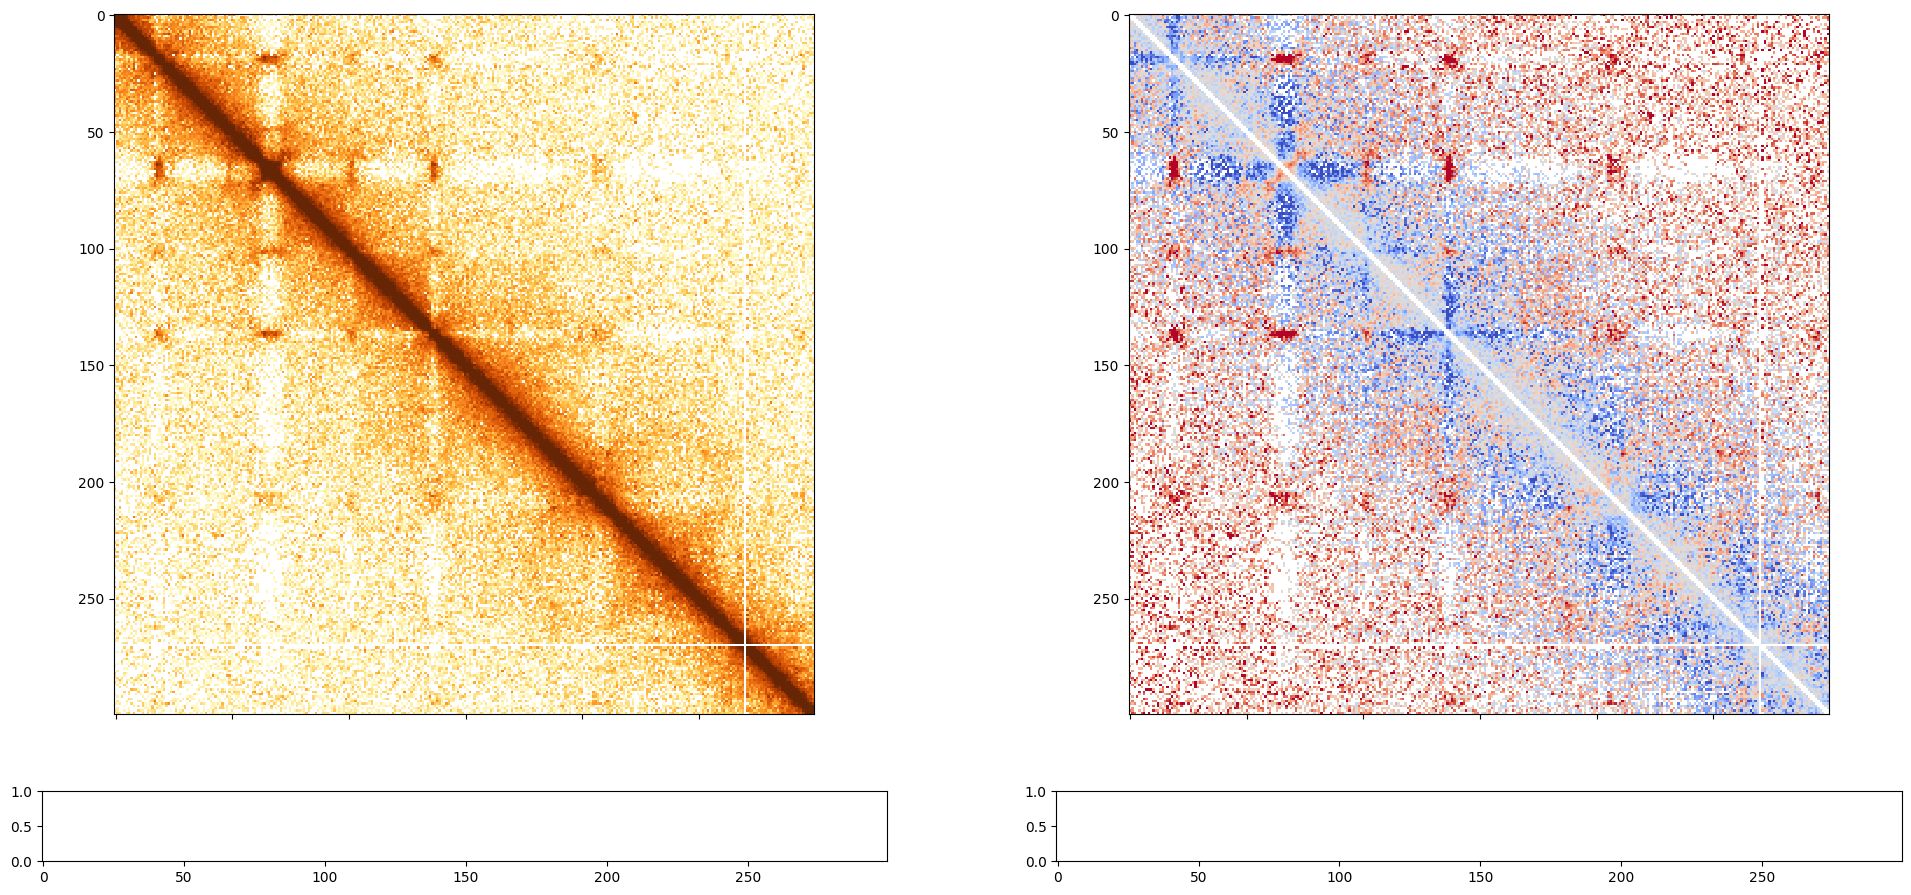

In [28]:
_region = (_chrom , _start, _end)
region_name = bioframe.select(hg38_arms, _region).iat[0,-1]
tile_span_i = clr.extent(_region)
tile_span_j = clr.extent(_region)

_the_tile = (region_name,tile_span_i, tile_span_j )

tile_start_ij = (tile_span_i[0], tile_span_j[0])
lazy_exp = LazyToeplitz(
    exp_indexed.loc[region_name, region_name]["balanced.avg"].to_numpy()
)
# RAW observed matrix slice:
observed = clr.matrix()[slice(*tile_span_i), slice(*tile_span_j)]
expected = lazy_exp[slice(*tile_span_i), slice(*tile_span_j)]

# let's figure out slices' coordinates ....
_bins_i = clr.bins()[slice(*tile_span_i)]
_bins_j = clr.bins()[slice(*tile_span_j)]
_chrom_i, _start_i, _end_i = _bins_i.iloc[0]["chrom"], _bins_i.iloc[0]["start"], _bins_i.iloc[-1]["end"]
_chrom_j, _start_j, _end_j = _bins_j.iloc[0]["chrom"], _bins_j.iloc[0]["start"], _bins_j.iloc[-1]["end"]

f, axs = plt.subplots(nrows=2,ncols=2,figsize=(24,11),sharex=True,sharey=False, height_ratios=[1,0.1])
# f.suptitle(f"tile # {_tile_id} {(_chrom_i, _start_i, _end_i)} {(_chrom_j, _start_j, _end_j)}",y=0.9)
# print(f"tile # {_tile_id} {(_chrom_i, _start_i, _end_i)} {(_chrom_j, _start_j, _end_j)}")


axleft, axright = axs[0,0], axs[0,1]

axleft.imshow(
    observed,
    cmap="YlOrBr",
    interpolation="none",
    norm=LogNorm(0.0001, 0.01)
)
axright.imshow(
    (observed/expected),
    cmap="coolwarm",
    interpolation="none",
    norm=LogNorm(0.25, 4)
)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(
    xxx,  #[~filtered_pixels_annotated["labels"].str.endswith("-1")],
    _the_tile,
    loc="upper",
    lw=1,
    ec="limegreen",
    fc="limegreen"
):
    axleft.add_patch(box)
    x0, y0, dx, dy = box.get_bbox().bounds
    axs[1,0].axvspan(x0, x0+dx, facecolor='crimson', alpha=0.2)


# # draw rectangular "boxes" around pixels called as dots in the "region":
# for box in rectangles_around_dots_ww(
#     yyy,
#     _the_tile,
#     loc="upper",
#     lw=2,
#     ec="crimson",
#     fc="none",
#     halo=100,
# ):
#     axleft.add_patch(box)



# for box in rectangles_around_dots_ww(
#     _bedpe_region,
#     _the_tile,
#     loc="upper",
#     lw=1,
#     ec="darkgreen",
#     fc="none",
#     halo=100
# ):
#     axleft.axvspan(x0, x0+dx, facecolor='crimson', alpha=0.5)



# # draw rectangular "boxes" around pixels called as dots in the "region":
# for box in rectangles_around_dots_ww(
#     yyy,
#     _the_tile,
#     loc="upper",
#     lw=2,
#     ec="crimson",
#     fc="none",
#     halo=100,
# ):
#     x0, y0, dx, dy = box.get_bbox().bounds
#     axs[1,0].axvspan(x0, x0+dx, facecolor='crimson', alpha=0.5)



# for box in rectangles_around_dots_ww(
#     _bedpe_region,
#     _the_tile,
#     loc="upper",
#     lw=1,
#     ec="darkgreen",
#     fc="none",
#     halo=100
# ):
#     x0, y0, dx, dy = box.get_bbox().bounds
#     axs[1,0].axvspan(x0, x0+dx, facecolor='crimson', alpha=0.5)


# axleft.set_xticks([])
# axleft.set_yticks([])
# axright.set_xticks([])
# axright.set_yticks([])
# axs[1,0].set_xticks([])
# axs[1,0].set_yticks([])

# axs[1,1].set_xticks([])
# axs[1,1].set_yticks([])

In [33]:
bbox = box.get_bbox()
print(bbox)

Bbox(x0=208.0, y0=135.0, x1=210.0, y1=141.0)


In [34]:
bbox.bounds

(208.0, 135.0, 2.0, 6.0)

10 pixels are visible out of 10 ...


NameError: name 'yyy' is not defined

/data/sergpolly/localenv/lib/python3.10/site-packages/numpy/ma/core.py:858: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


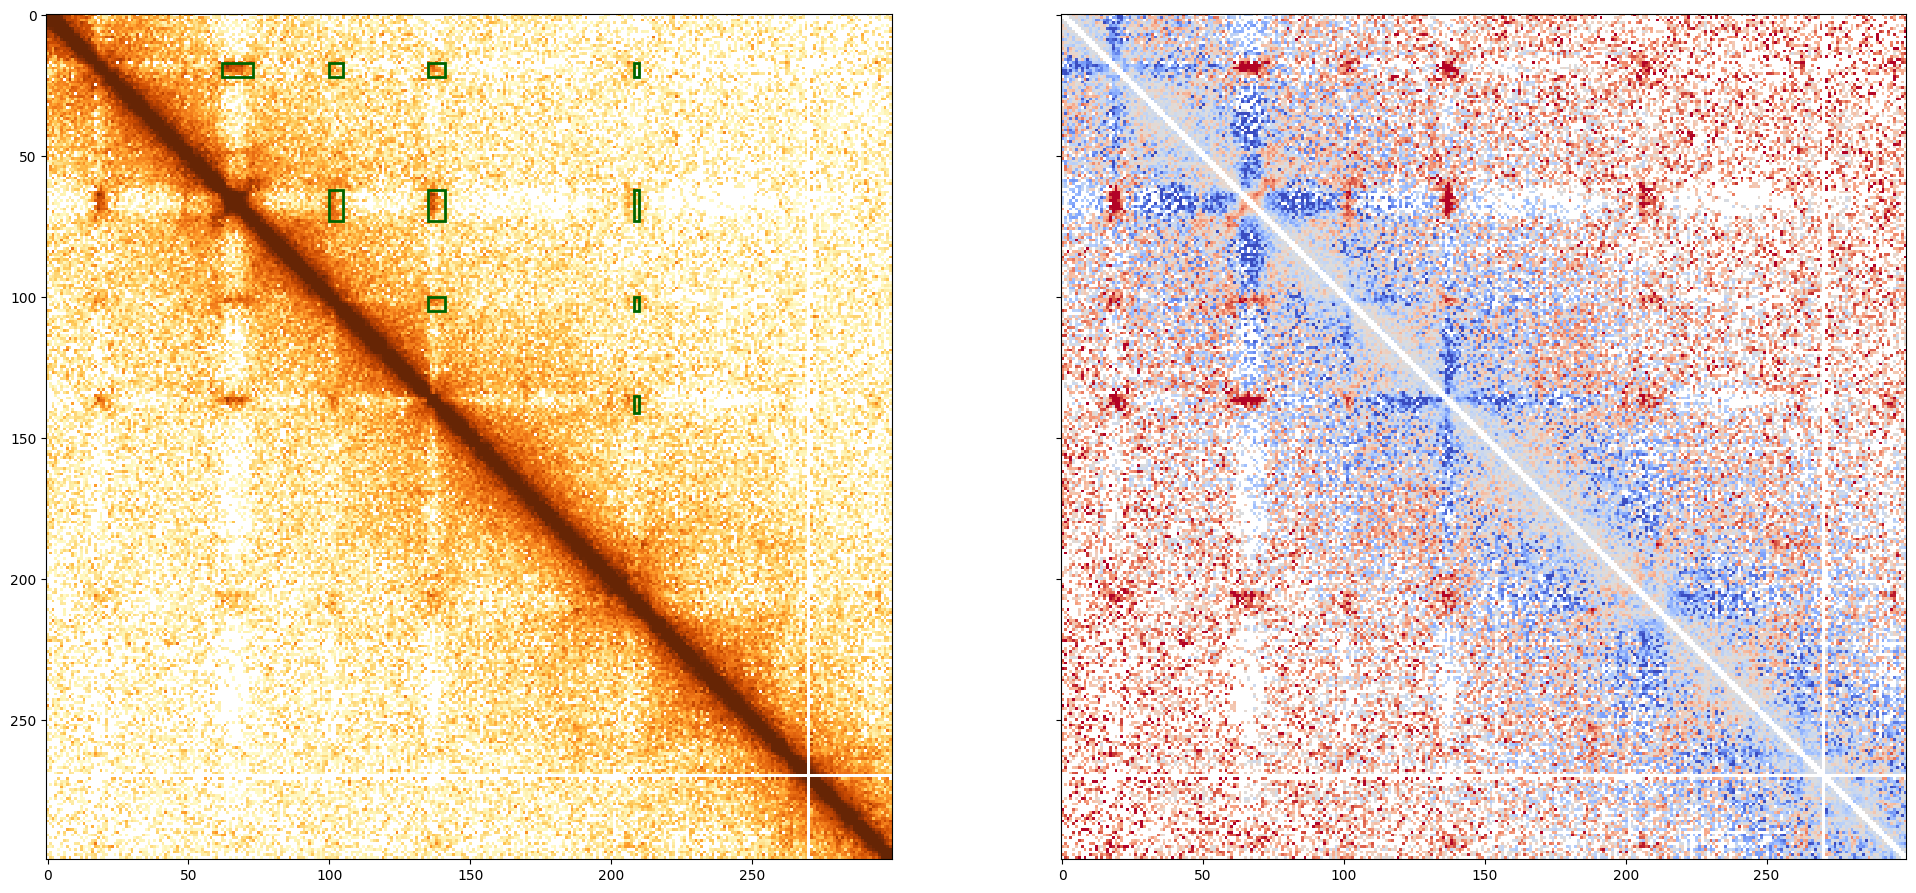

In [35]:
_region = (_chrom , _start, _end)
region_name = bioframe.select(hg38_arms, _region).iat[0,-1]
tile_span_i = clr.extent(_region)
tile_span_j = clr.extent(_region)

_the_tile = (region_name,tile_span_i, tile_span_j )

tile_start_ij = (tile_span_i[0], tile_span_j[0])
lazy_exp = LazyToeplitz(
    exp_indexed.loc[region_name, region_name]["balanced.avg"].to_numpy()
)
# RAW observed matrix slice:
observed = clr.matrix()[slice(*tile_span_i), slice(*tile_span_j)]
expected = lazy_exp[slice(*tile_span_i), slice(*tile_span_j)]

# let's figure out slices' coordinates ....
_bins_i = clr.bins()[slice(*tile_span_i)]
_bins_j = clr.bins()[slice(*tile_span_j)]
_chrom_i, _start_i, _end_i = _bins_i.iloc[0]["chrom"], _bins_i.iloc[0]["start"], _bins_i.iloc[-1]["end"]
_chrom_j, _start_j, _end_j = _bins_j.iloc[0]["chrom"], _bins_j.iloc[0]["start"], _bins_j.iloc[-1]["end"]


f, (axleft, axright) = plt.subplots(nrows=1,ncols=2,figsize=(24,11),sharex=True,sharey=True)
# f.suptitle(f"tile # {_tile_id} {(_chrom_i, _start_i, _end_i)} {(_chrom_j, _start_j, _end_j)}",y=0.9)

# print(f"tile # {_tile_id} {(_chrom_i, _start_i, _end_i)} {(_chrom_j, _start_j, _end_j)}")

axleft.imshow(
    observed,
    cmap="YlOrBr",
    interpolation="none",
    norm=LogNorm(0.0001, 0.01)
)
axright.imshow(
    (observed/expected),
    cmap="coolwarm",
    interpolation="none",
    norm=LogNorm(0.25, 4)
)

# # draw rectangular "boxes" around pixels called as dots in the "region":
# for box in rectangles_around_dots(
#     xxx,  #[~filtered_pixels_annotated["labels"].str.endswith("-1")],
#     _the_tile,
#     loc="upper",
#     lw=1,
#     ec="cyan",
#     fc="none"
# ):
#     axleft.add_patch(box)

# # draw rectangular "boxes" around pixels called as dots in the "region":
# for box in rectangles_around_dots_ww(
#     yyy,
#     _the_tile,
#     loc="upper",
#     lw=1,
#     ec="k",
#     fc="none",
#     halo=100,
# ):
#     axleft.add_patch(box)
for box in rectangles_around_dots_ww(
    _bedpe_region,
    _the_tile,
    loc="upper",
    lw=2,
    ec="darkgreen",
    fc="none",
    halo=100
):
    axleft.add_patch(box)
for box in rectangles_around_dots_ww(
    yyy,
    _the_tile,
    loc="upper",
    lw=2,
    ec="crimson",
    fc="none",
    halo=100
):
    axleft.add_patch(box)


# for box in rectangles_around_dots_ww(
#     _bedpe_region,
#     _the_tile,
#     loc="upper",
#     lw=2,
#     ec="limegreen",
#     fc="none",
#     halo=100
# ):
#     axright.add_patch(box)


In [36]:
sum(_2d_mask)

8

In [37]:
_nnn = len(_bedpe_region["cluster1"].unique())+1

assert (_nnn*_nnn - _nnn)/2 == len(_bedpe_region)

In [38]:
_flank = 75_000 # Length of flank to one side from the boundary, in basepairs
# create the stack of snips:
_region_stack = cooltools.pileup(
    clr,
    _bedpe_region,
    view_df=hg38_arms,
    expected_df=exp,
    flank=_flank,
    nproc=12
)

/data/sergpolly/cooltools/cooltools/api/snipping.py:967: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df["region1_offset"] = features_df["region1"].replace(
/data/sergpolly/cooltools/cooltools/api/snipping.py:978: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df["region2_offset"] = features_df["region2"].replace(


/data/sergpolly/localenv/lib/python3.10/site-packages/numpy/ma/core.py:858: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


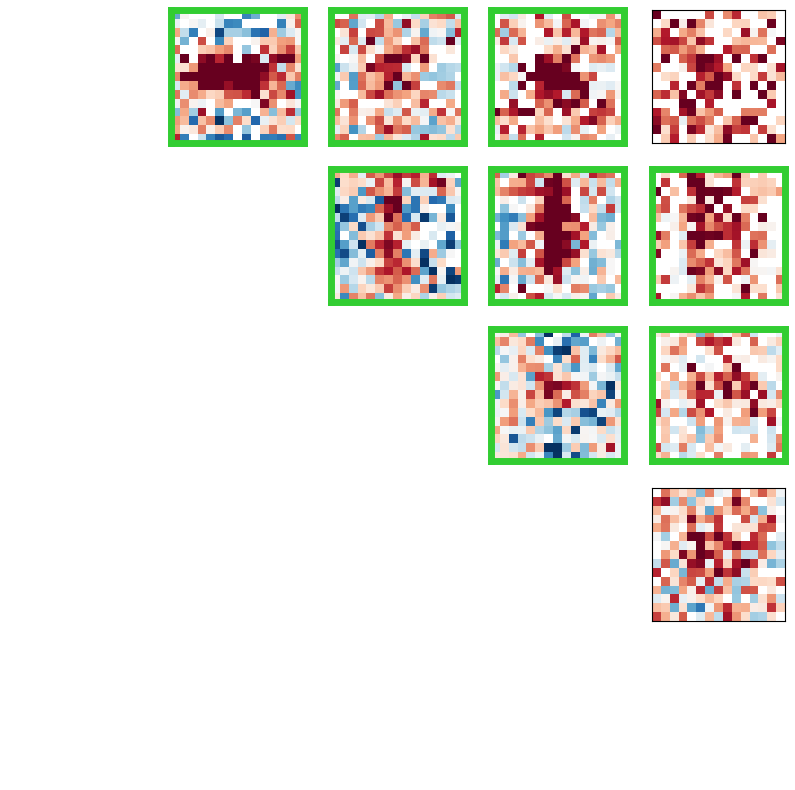

In [39]:
_number = len(_bedpe_region["cluster1"].unique())+1
_width_unit = 2
_height_unit = 2
nrows, ncols = _number, _number
f,axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize = (nrows*_height_unit, ncols*_width_unit),
    sharex=True,
    sharey=True,
)

imshow_kwargs = dict(
    norm=LogNorm(vmin=1/4,vmax=4),
    # norm = mpl.colors.Normalize(vmin=1-0.9999,vmax=1+0.9999),
    interpolation="none",
    # extent=[-_flank//1000, _flank//1000, -_flank//1000, _flank//1000],
    cmap='RdBu_r',
)

_counter = 0
for i in range(nrows):
    for j in range(ncols):
        _ax = axs[i,j]
        if j == i:
            _ax.set_axis_off()
            # _ax.set_xticks([])
            # _ax.set_yticks([])
        elif j > i:
            _ax.set_xticks([])
            _ax.set_yticks([])
            _ax.imshow(_region_stack[_counter], **imshow_kwargs)
            if _2d_mask[_counter]:
                _ax.spines["left"].set_color("limegreen")
                _ax.spines["right"].set_color("limegreen")
                _ax.spines["top"].set_color("limegreen")
                _ax.spines["bottom"].set_color("limegreen")
                _ax.spines["left"].set_linewidth(5)
                _ax.spines["right"].set_linewidth(5)
                _ax.spines["top"].set_linewidth(5)
                _ax.spines["bottom"].set_linewidth(5)
            _counter += 1
            #
        else:
            _ax.set_axis_off()
